Import all necessary packages

In [1]:
import numpy as np ### numpy for array modifications
import pandas as pd ### pandas for dataframe handling
import seaborn as sns ### seaborn for data vis

from sklearn.linear_model import LinearRegression ### regression model from sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import re
import matplotlib.pyplot as plt

from nba_api.stats.static import players ### all nba players -- not box score data, just player IDs
from nba_api.stats.static import teams ### all nba teams -- not box score data, just teans IDs
from nba_api.stats.endpoints import playergamelog ### player game stats
from nba_api.stats.endpoints import leaguegamefinder ### team game stats
from nba_api.stats.endpoints import teamgamelog ### team game logs
from nba_api.stats.endpoints import commonplayerinfo

In [2]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [4]:
from tensorflow.keras.layers import LayerNormalization

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
from tensorflow.keras.layers import Dropout

In [7]:
from tensorflow.keras.layers import BatchNormalization

In [8]:
# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.13.0


Creating a dictionary of all players all time.

In [9]:
player_dict = players.get_players() 

Creating a dictionary of all active players.

In [10]:
active_player_dict = [player for player in player_dict if player['is_active'] ==  True]

A function that finds the player id given the player name.

The parameter player_name is a string.

The output is the corresponding players's id as an int.

In [11]:
def player_id_finder(player_name):
    for player in active_player_dict:
        if player['full_name'] == player_name:
            return player['id']

The below creates a dictionary, pairing each team's abbreviation with the full team name.

In [12]:
team_abbr = ['ATL', 'BOS', 'BKN', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']
team_full = ['Atlanta Hawks','Boston Celtics','Brooklyn Nets','Charlotte Hornets','Chicago Bulls','Cleveland Cavaliers','Dallas Mavericks','Denver Nuggets','Detroit Pistons','Golden State Warriors','Houston Rockets','Indiana Pacers','Los Angeles Clippers','Los Angeles Lakers','Memphis Grizzlies','Miami Heat','Milwaukee Bucks','Minnesota Timberwolves','New Orleans Pelicans','New York Knicks','Oklahoma City Thunder','Orlando Magic','Philadelphia 76ers','Phoenix Suns','Portland Trail Blazers','Sacramento Kings','San Antonio Spurs','Toronto Raptors', 'Utah Jazz', 'Washington Wizards']
team_name_dict = {k:v for k, v in zip(team_abbr,team_full)}

Creating a dictionary of all teams.

In [13]:
team_dict = teams.get_teams()

A function that finds the team id given the team name.

The parameter team_name is a string.

The output is the corresponding team's id as an int.

In [14]:
def team_id_finder(team_name):
    for team in team_dict:
        if team['full_name'] == team_name:
            return team['id']

A function that saves team data by season as a csv file.

The parameters
- seasons_list: list (of seasons in format [20xx-xx, 20xx-xx, ...]
- season_type: str ('Regular Season', 'Playoffs')

The Output
- saves the dataframe created from the API call as a csv file (no output)

In [15]:
def save_team_datasets(seasons_list, season_type):
    for season in seasons_list:
        print('loading season', season)
        df = leaguegamefinder.LeagueGameFinder(season_nullable = season, league_id_nullable = '00', season_type_nullable = season_type).get_data_frames()[0]
        filename = str(season) + 'teams' + re.match(r'^\w+', season_type).group(0) + '.csv'
        print(filename)
        df.to_csv(filename, index=False)
        print('Successully saved', filename)

In [16]:
def save_player_datasets(seasons_list, season_type):
    for season in seasons_list:
        print('loading season', season)
        df = leaguegamefinder.LeagueGameFinder(player_or_team_abbreviation='P' ,season_nullable = season, league_id_nullable = '00', season_type_nullable = season_type).get_data_frames()[0]
        filename = str(season) + 'players' + re.match(r'^\w+', season_type).group(0) + '.csv'
        print(filename)
        df.to_csv(filename, index=False)
        print('Successully saved', filename)

Using a call from nba_api to download player and team data from the past 5 seasons from the regular season and playoffs as csv files.

Saving the csv files from the most recent (2023) season as dataframe variables.

In [17]:
#seasons_list = ['2018-19', '2019-20', '2020-21', '2021-22', '2022-23']
seasons_list = ['2023-24']
#save_team_datasets(seasons_list, 'Regular Season')

In [18]:
save_player_datasets(seasons_list, 'Regular Season')
save_team_datasets(seasons_list, 'Regular Season')

loading season 2023-24
2023-24playersRegular.csv
Successully saved 2023-24playersRegular.csv
loading season 2023-24
2023-24teamsRegular.csv
Successully saved 2023-24teamsRegular.csv


In [19]:
players_2023 = pd.read_csv('2022-23playersRegular.csv')

In [20]:
teams_2023 = pd.read_csv('2022-23teamsRegular.csv')

In [21]:
players_2024 = pd.read_csv('2023-24playersRegular.csv')
teams_2024 = pd.read_csv('2023-24teamsRegular.csv')

In [22]:
#save_team_datasets(seasons_list, 'Playoffs')

In [23]:
#save_player_datasets(seasons_list, 'Playoffs')

In [24]:
players_2023_playoffs = pd.read_csv('2022-23playersPlayoffs.csv')

In [25]:
teams_2023_playoffs = pd.read_csv('2022-23teamsPlayoffs.csv')

A function that compares a player's offensive stats (pt, reb, ast) to the opponents defensive rating. The function returns regression plots showing how well of a predictor opponent defensive rating is for the player's offensive stats.

The parameters
- player name: str
- players_df: pandas dataframe (of players' stats data)
- teams_df: pandas dataframe (of teams' stats data)

The output

- Three regression plots that graph opponent defensive rating (x) against player offenseive stats (y)
- R-squared values of the models to gauge performance

In [26]:
def player_off_trends(player_name, players_df, teams_df):
    #retrieve the players stats from the player_df
    player_df = players_df[players_df['PLAYER_NAME'] == player_name].copy()

    #retrieve the ids of the games the player played in
    player_game_ids = list(player_df['GAME_ID'])

    #retreieve the stats from the teams in all the games the player played in
    player_games = teams_df[teams_df['GAME_ID'].isin(player_game_ids)].copy()

    #create a set of player team ids --> incase they are traded midseason and play for different teams
    player_team_id_set = set(list(player_df['TEAM_ID']))
    
    #calculate the opposing team's defensive rating (opponent's points)/(possesions) * 100 where possesions = (FGA - OREB + TOV + (FTA * 0.4))
    team_pts = np.array(player_games.loc[player_games['TEAM_ID'].isin(player_team_id_set)]['PTS'])
    team_fga = np.array(player_games.loc[player_games['TEAM_ID'].isin(player_team_id_set)]['FGA'])
    team_oreb = np.array(player_games.loc[player_games['TEAM_ID'].isin(player_team_id_set)]['OREB'])
    team_tov = np.array(player_games.loc[player_games['TEAM_ID'].isin(player_team_id_set)]['TOV'])
    team_fta = np.array(player_games.loc[player_games['TEAM_ID'].isin(player_team_id_set)]['FTA'])

    opp_def_ratings = (team_pts)/(team_fga - team_oreb + team_tov + (team_fta * 0.4)) * 100

    #create a dictionary mapping the game ids to the def ratings.
    id_def_rating_dict = {k:v for k,v in zip(player_game_ids, opp_def_ratings)}

    #map the opponent defensive rating onto player_df
    player_df.loc[:, 'opp_def_rating'] = player_df['GAME_ID'].map(id_def_rating_dict)

    #plot regression lines and find basic stats.
    x = np.array(player_df['opp_def_rating']).reshape(-1, 1)
    
    sns.lmplot(data=player_df, x='opp_def_rating', y='PTS')
    y1 = list(player_df['PTS'])
    pts_model = LinearRegression().fit(x, y1)
    print('R-squared for pts:', pts_model.score(x,y1))
    
    sns.lmplot(data=player_df, x='opp_def_rating', y='REB')
    y2 = list(player_df['REB'])
    pts_model = LinearRegression().fit(x, y2)
    print('R-squared for reb:', pts_model.score(x,y2))
          
    sns.lmplot(data=player_df, x='opp_def_rating', y='AST')
    y3 = list(player_df['AST'])
    pts_model = LinearRegression().fit(x, y3)
    print('R-squared for ast:', pts_model.score(x,y3))

Example of player_off_trends

R-squared for pts: 0.14587291666493474
R-squared for reb: 0.0031029437604026544
R-squared for ast: 0.11544092990068389


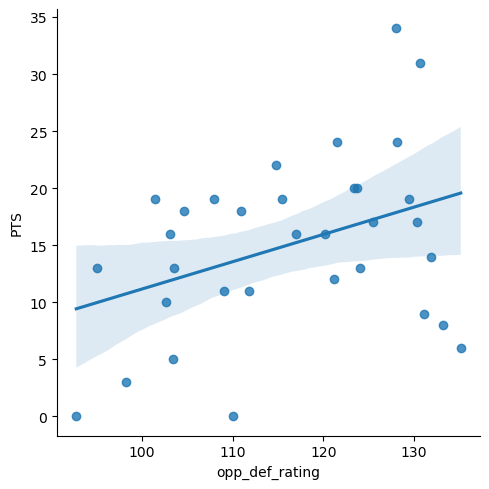

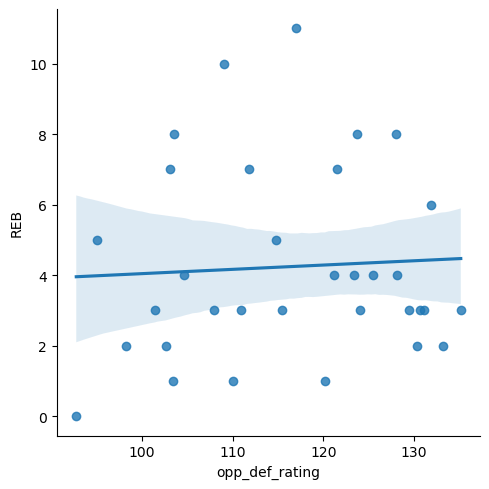

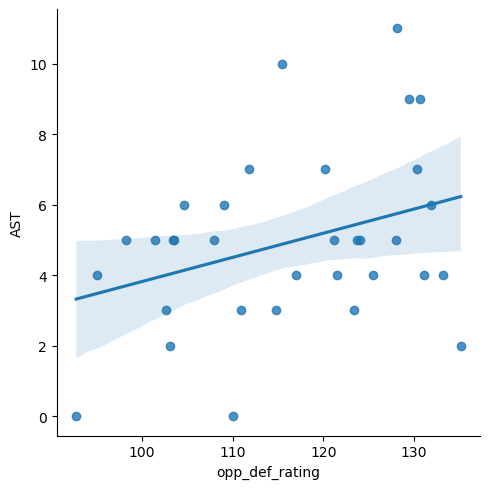

In [27]:
player_off_trends('Khris Middleton', players_2023, teams_2023)

A function that compares a players' points scored and the fraction of the team's points that they scored. The function returns a regression plot displaying the performance of the fraction of the team's points scored as a predictor for points scored.

The parameters:
- player name: str
- players_df: pandas dataframe (of players' stats data)
- teams_df: pandas dataframe (of teams' stats data)

The output

- A regression plot that graphs fraction of points scored (x) against points scored (y)
- R-squared value of the models to gauge performance

In [28]:
def player_team_point_comp(player_name, players_df, teams_df):
    player_df = players_2023[players_2023['PLAYER_NAME'] == player_name].copy()

    player_game_ids = list(player_df['GAME_ID'])
    player_team_ids = set(list(player_df['TEAM_ID']))
    player_games = teams_2023[teams_2023['GAME_ID'].isin(player_game_ids)].copy()
    player_team_games = player_games[player_games['TEAM_ID'].isin(player_team_ids)]
    team_points = list(player_team_games['PTS'])

    player_team_points_dict = {k:v for k,v in zip(player_game_ids, team_points)}

    player_df.loc[:, 'team_score'] = player_df['GAME_ID'].map(player_team_points_dict)
    player_df.loc[:, 'player/team'] = player_df['PTS']/player_df['team_score']

    x= np.array(player_df['player/team']).reshape(-1,1)
    
    y= np.array(player_df['PTS'])

    sns.lmplot(data=player_df, x='player/team', y='PTS')
    model = LinearRegression().fit(x,y)
    print('R-Squared:', model.score(x,y))
    
    

R-Squared: 0.8658229809053406


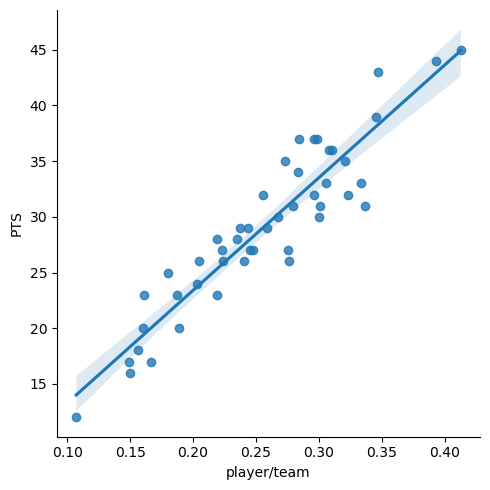

In [29]:
player_team_point_comp('Kevin Durant', players_2023, teams_2023)

A function that compares a players' points scored and the fraction of the team's field goals that they attempted. The function returns a regression plot displaying the performance of the fraction of the team's field goals attempted as a predictor for points scored.

The parameters:
- player name: str
- players_df: pandas dataframe (of players' stats data)
- teams_df: pandas dataframe (of teams' stats data)

The output

- A regression plot that graphs fraction of field goals attempted (x) against points scored (y)
- R-squared value of the models to gauge performance

In [30]:
def player_points_percent_fga_comp(player_name, players_df, teams_df):
    player_df = players_2023[players_2023['PLAYER_NAME'] == player_name].copy()

    player_game_ids = list(player_df['GAME_ID'])
    player_team_ids = set(list(player_df['TEAM_ID']))
    player_games = teams_df[teams_df['GAME_ID'].isin(player_game_ids)].copy()
    player_team_games = player_games[player_games['TEAM_ID'].isin(player_team_ids)]
    team_fga = list(player_team_games['FGA'])

    game_id_team_fga_dict = {k:v for k,v in zip(player_game_ids, team_fga)}

    player_df.loc[:, 'team_fga'] = player_df['GAME_ID'].map(game_id_team_fga_dict)
    player_df.loc[:, 'player/team'] = player_df['FGA']/player_df['team_fga']

    x= np.array(player_df['player/team']).reshape(-1,1)
    
    y= np.array(player_df['PTS'])

    sns.lmplot(data=player_df, x='player/team', y='PTS')
    model = LinearRegression().fit(x,y)
    print('R-Squared:', model.score(x,y))
    

R-Squared: 0.4413958849775852


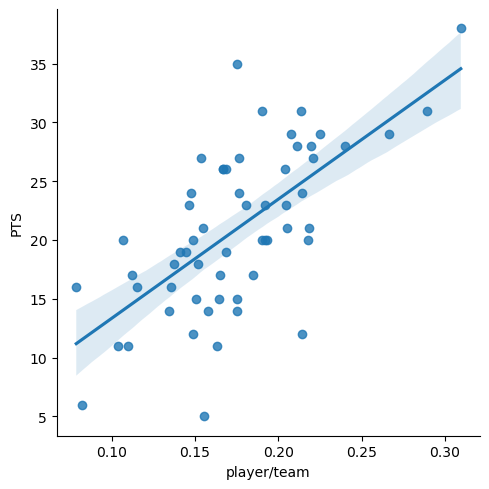

In [31]:
player_points_percent_fga_comp('James Harden', players_2023, teams_2023)

A function that compares a team's steals recorded and the amount of turnovers commited by the opponent. The function returns a regression plot displaying the performance of opponent turnovers as a predictor for team steals.

The parameters:
- team_name: str
- teams_df: pandas dataframe (of teams' stats data)

The output

- A regression plot that graphs opponent turnvoers (x) against team steals (y)
- R-squared value of the models to gauge performance

In [32]:
def stl_tov_trends(team_name, teams_df):

    #retrieve the stats from the teams in all the games the team played in
    team_games = teams_df[teams_df['TEAM_NAME']==team_name].copy()
    team_game_ids = list(team_games['GAME_ID'])
    opp_team_games = teams_df[teams_df['GAME_ID'].isin(team_game_ids)].copy()
    opp_team_tovs = opp_team_games[opp_team_games['TEAM_ID'] != team_id_finder(team_name)]
    
    #retrieve turnovers and steals
    
    opp_tovs = np.array(opp_team_tovs['TOV'])
    
                                       
    #create a dictionary mapping the game ids to the def ratings.
    id_tov_stl_dict = {k:v for k,v in zip(team_game_ids, opp_tovs)}

    #map the opponent defensive rating onto player_df
    team_games.loc[:, 'opp_tovs'] = team_games['GAME_ID'].map(id_tov_stl_dict)

    #plot regression lines and find basic stats.
    x = np.array(team_games['opp_tovs']).reshape(-1, 1)
    y = np.array(team_games['STL'])
    
    sns.lmplot(data=team_games, x='opp_tovs', y='STL')
    stls_model = LinearRegression().fit(x, y)
    print('R-squared:', stls_model.score(x,y))

R-squared: 0.5821400323556429


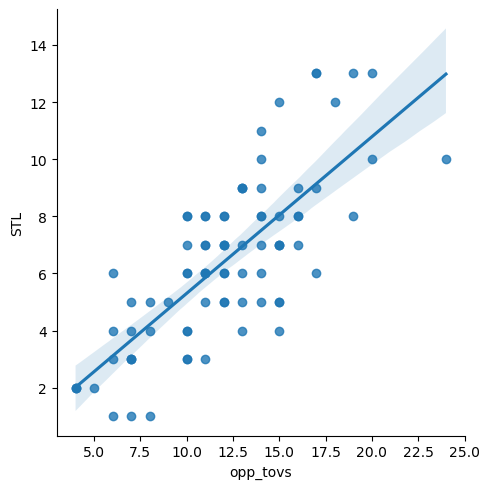

In [33]:
stl_tov_trends('New York Knicks', teams_2023)

In [34]:
def point_prediction_1(player_name, players_df, teams_df):
    #create player_df from players_df
    player_df = players_df[players_df['PLAYER_NAME'] == player_name].copy()
    
    #extract player game IDs
    player_game_ids = list(player_df['GAME_ID'])
    
    #extract team (opponent and team that player is on) data from games that player played in
    player_games = teams_df[teams_df['GAME_ID'].isin(player_game_ids)].copy()
    
    #extract team IDs of all the teams that the player was on during the season
    player_team_ids = set(list(player_df['TEAM_ID']))
    
    #create df of stats from the teams that the player played on only (not opposing teams' data)
    player_team_games = player_games[player_games['TEAM_ID'].isin(player_team_ids)].copy()
    
    #extract team fga from player_team_games
    team_fga = list(player_team_games['FGA'])
    
    #create a dictionary linking player_game_ids to team FGA
    game_id_team_fga_dict = {k:v for k,v in zip(player_game_ids, team_fga)}
    
    #map team_fga to player_df
    player_df.loc[:, 'team_fga'] = player_df['GAME_ID'].map(game_id_team_fga_dict)
    
    #calculate the percentage of the teams field goal attempts a player takes (FACTOR 1)
    player_df.loc[:, 'playerFGA%'] = player_df['FGA']/player_df['team_fga']
    
    #calculate the players eFG% (FACTOR 2)
    player_FGM = np.array(player_df['FGM'])
    player_ThreePM = np.array(player_df['FG3M'])
    player_FGA = np.array(player_df['FGA'])
    
    player_df.loc[:, 'eFG%'] = (player_FGM + (0.5 * player_ThreePM))/player_FGA
    
    team_points = list(player_team_games['PTS'])
    player_team_points_dict = {k:v for k,v in zip(player_game_ids, team_points)}

    player_df.loc[:, 'team_score'] = player_df['GAME_ID'].map(player_team_points_dict)
    player_df.loc[:, 'player/team'] = player_df['PTS']/player_df['team_score']
    
    #define the variables
    x = player_df[['FGA', 'eFG%', 'FTA', 'FT_PCT', 'player/team']].fillna(0)
    y = player_df['PTS']
    
    model = LinearRegression().fit(x,y)
    
    return model

In [35]:
def point_prediction_1_test_data(player_name, players_df, teams_df):
    #create player_df from players_df
    player_df = players_df[players_df['PLAYER_NAME'] == player_name].copy()
    
    #extract player game IDs
    player_game_ids = list(player_df['GAME_ID'])
    
    #extract team (opponent and team that player is on) data from games that player played in
    player_games = teams_df[teams_df['GAME_ID'].isin(player_game_ids)].copy()
    
    #extract team IDs of all the teams that the player was on during the season
    player_team_ids = set(list(player_df['TEAM_ID']))
    
    #create df of stats from the teams that the player played on only (not opposing teams' data)
    player_team_games = player_games[player_games['TEAM_ID'].isin(player_team_ids)].copy()
    
    #extract team fga from player_team_games
    team_fga = list(player_team_games['FGA'])
    
    #create a dictionary linking player_game_ids to team FGA
    game_id_team_fga_dict = {k:v for k,v in zip(player_game_ids, team_fga)}
    
    #map team_fga to player_df
    player_df.loc[:, 'team_fga'] = player_df['GAME_ID'].map(game_id_team_fga_dict)
    
    #calculate the percentage of the teams field goal attempts a player takes (FACTOR 1)
    player_df.loc[:, 'playerFGA'] = player_df['FGA']/player_df['team_fga']
    
    #calculate the players eFG% (FACTOR 2)
    player_FGM = np.array(player_df['FGM'])
    player_ThreePM = np.array(player_df['FG3M'])
    player_FGA = np.array(player_df['FGA'])
    
    player_df.loc[:, 'eFG%'] = (player_FGM + (0.5 * player_ThreePM))/player_FGA
    
    team_points = list(player_team_games['PTS'])
    player_team_points_dict = {k:v for k,v in zip(player_game_ids, team_points)}

    player_df.loc[:, 'team_score'] = player_df['GAME_ID'].map(player_team_points_dict)
    player_df.loc[:, 'player/team'] = player_df['PTS']/player_df['team_score']
    
    return player_df

In [36]:
def test_prediction_model_1(player_name, playersRegular_df, teamsRegular_df, playersPlayoff_df, teamsPlayoff_df, prediction_model, test_data):
    # create model
    model = prediction_model(player_name, playersRegular_df, teamsRegular_df)
    
    # extract playoff test data
    test_df = test_data(player_name, playersPlayoff_df, teamsPlayoff_df)
    
    # collect x and y test data. 
    # X is the data that we feed into the model. 
    # Y is the actual outcome to compare against the predicted values.
    x_test = test_df[['FGA', 'eFG%', 'FTA', 'FT_PCT', 'player/team']].fillna(0)
    y_test = np.array(test_df['PTS'])
    
    # Generate the predictions.
    y_pred = model.predict(x_test)
    
    # Create a graph to visualize the results
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Points scored by' + player_name)
    plt.ylabel('Predicted Points scored by' +  player_name)
    plt.show()
    
    #Calculate the Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print('Mean Squared Error:', mse)
    
    #Calculate the R-Squared
    r2 = r2_score(y_test, y_pred)
    print('R-squared:', r2)

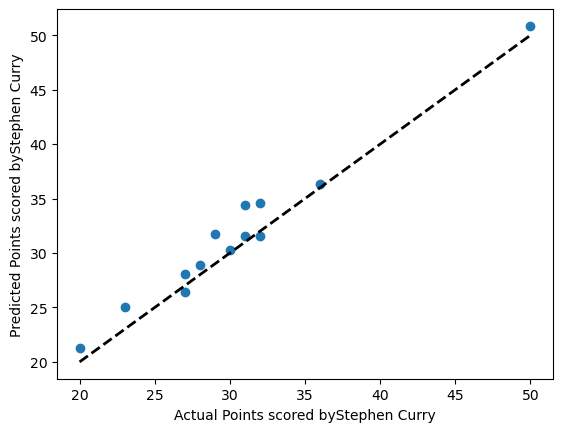

Mean Squared Error: 2.744830427516185
R-squared: 0.9420009574580851


In [37]:
test_prediction_model_1('Stephen Curry', players_2023, teams_2023, players_2023_playoffs, 
                       teams_2023_playoffs, point_prediction_1, point_prediction_1_test_data)

In [38]:
def point_prediction_2(player_name, players_df, teams_df):
    #create player_df from players_df
    player_df = players_df[players_df['PLAYER_NAME'] == player_name].copy()
    
    #extract player game IDs
    player_game_ids = list(player_df['GAME_ID'])
    
    #extract team (opponent and team that player is on) data from games that player played in
    player_games = teams_df[teams_df['GAME_ID'].isin(player_game_ids)].copy()
    
    #extract team IDs of all the teams that the player was on during the season
    player_team_ids = set(list(player_df['TEAM_ID']))
    
    #create df of stats from the teams that the player played on only (not opposing teams' data)
    player_team_games = player_games[player_games['TEAM_ID'].isin(player_team_ids)].copy()
    
    #extract team fga from player_team_games
    team_fga = list(player_team_games['FGA'])
    
    #extract team fta from player_team_games
    team_fta = list(player_team_games['FTA'])
    
    #create a dictionary linking player_game_ids to team FGA
    game_id_team_fga_dict = {k:v for k,v in zip(player_game_ids, team_fga)}
    
    #create a dictionary linking player_game_ids to team FTA
    game_id_team_fta_dict = {k:v for k,v in zip(player_game_ids, team_fta)}
    
    #map team_fga to player_df
    player_df.loc[:, 'team_fga'] = player_df['GAME_ID'].map(game_id_team_fga_dict)
    
    #map team fta to player_df
    player_df.loc[:, 'team_fta'] = player_df['GAME_ID'].map(game_id_team_fta_dict)
    
    #calculate the percentage of the teams field goal attempts a player takes (FACTOR 1)
    player_df.loc[:, 'playerFGA%'] = player_df['FGA']/player_df['team_fga']
    
    #calculate the percentage of the teams field goal attempts a player takes (FACTOR 2)
    player_df.loc[:, 'playerFTA%'] = player_df['FGA']/player_df['team_fga']
    
    #calculate the players eFG% (FACTOR 3)
    player_FGM = np.array(player_df['FGM'])
    player_ThreePM = np.array(player_df['FG3M'])
    player_FGA = np.array(player_df['FGA'])
    
    player_df.loc[:, 'eFG%'] = (player_FGM + (0.5 * player_ThreePM))/player_FGA
    
    #calculate the percentage of the team's points a players scores 
    team_points = list(player_team_games['PTS'])
    player_team_points_dict = {k:v for k,v in zip(player_game_ids, team_points)}

    player_df.loc[:, 'team_score'] = player_df['GAME_ID'].map(player_team_points_dict)
    player_df.loc[:, 'player/team'] = player_df['PTS']/player_df['team_score']
    
    #calculate the player's usage rate
    player_tov = np.array(player_df['TOV'])
    player_min = np.array(player_df['MIN'])
    player_ast = np.array(player_df['AST'])
    player_fta = np.array(player_df['FTA'])
    
    team_tov = list(player_team_games['TOV'])
    team_oreb = list(player_team_games['OREB'])
    
    game_id_team_tov_dict = {k:v for k,v in zip(player_game_ids, team_tov)}
    game_id_team_oreb_dict = {k:v for k,v in zip(player_game_ids, team_oreb)}
    
    player_df.loc[:, 'team_tov'] = player_df['GAME_ID'].map(game_id_team_tov_dict)
    player_df.loc[:, 'team_oreb'] = player_df['GAME_ID'].map(game_id_team_oreb_dict)
    
    player_df.loc[:, 'usageRate'] = (100 * ((0.33 * player_ast) + player_FGA + (0.44 * player_fta) + player_tov))/(player_df['team_fga'] - player_df['team_oreb'] + player_df['team_tov'] + (0.4 * player_df['team_fga']))    
    
    #define the variables (FGA instead of FGA%)
    x = player_df[['FGA', 'eFG%', 'FTA', 'FT_PCT', 'player/team', 'usageRate', 'MIN']].fillna(0)
    y = player_df['PTS']
    
    model = LinearRegression().fit(x,y)
    
    return model

In [39]:
def point_prediction_2_test_data(player_name, players_df, teams_df):
    #create player_df from players_df
    player_df = players_df[players_df['PLAYER_NAME'] == player_name].copy()
    
    #extract player game IDs
    player_game_ids = list(player_df['GAME_ID'])
    
    #extract team (opponent and team that player is on) data from games that player played in
    player_games = teams_df[teams_df['GAME_ID'].isin(player_game_ids)].copy()
    
    #extract team IDs of all the teams that the player was on during the season
    player_team_ids = set(list(player_df['TEAM_ID']))
    
    #create df of stats from the teams that the player played on only (not opposing teams' data)
    player_team_games = player_games[player_games['TEAM_ID'].isin(player_team_ids)].copy()
    
    #extract team fga from player_team_games
    team_fga = list(player_team_games['FGA'])
    
    #extract team fta from player_team_games
    team_fta = list(player_team_games['FTA'])
    
    #create a dictionary linking player_game_ids to team FGA
    game_id_team_fga_dict = {k:v for k,v in zip(player_game_ids, team_fga)}
    
    #create a dictionary linking player_game_ids to team FTA
    game_id_team_fta_dict = {k:v for k,v in zip(player_game_ids, team_fta)}
    
    #map team_fga to player_df
    player_df.loc[:, 'team_fga'] = player_df['GAME_ID'].map(game_id_team_fga_dict)
    
    #map team fta to player_df
    player_df.loc[:, 'team_fta'] = player_df['GAME_ID'].map(game_id_team_fta_dict)
    
    #calculate the percentage of the teams field goal attempts a player takes (FACTOR 1)
    player_df.loc[:, 'playerFGA%'] = player_df['FGA']/player_df['team_fga']
    
    #calculate the percentage of the teams field goal attempts a player takes (FACTOR 2)
    player_df.loc[:, 'playerFTA%'] = player_df['FGA']/player_df['team_fga']
    
    #calculate the percentage of the team's points a players scores 
    team_points = list(player_team_games['PTS'])
    player_team_points_dict = {k:v for k,v in zip(player_game_ids, team_points)}

    player_df.loc[:, 'team_score'] = player_df['GAME_ID'].map(player_team_points_dict)
    player_df.loc[:, 'player/team'] = player_df['PTS']/player_df['team_score']
    
    #calculate the players eFG% (FACTOR 3)
    player_FGM = np.array(player_df['FGM'])
    player_ThreePM = np.array(player_df['FG3M'])
    player_FGA = np.array(player_df['FGA'])
    
    player_df.loc[:, 'eFG%'] = (player_FGM + (0.5 * player_ThreePM))/player_FGA
    
        #calculate the player's usage rate
    player_tov = np.array(player_df['TOV'])
    player_min = np.array(player_df['MIN'])
    player_ast = np.array(player_df['AST'])
    player_fta = np.array(player_df['FTA'])
    
    team_tov = list(player_team_games['TOV'])
    team_oreb = list(player_team_games['OREB'])
    
    game_id_team_tov_dict = {k:v for k,v in zip(player_game_ids, team_tov)}
    game_id_team_oreb_dict = {k:v for k,v in zip(player_game_ids, team_oreb)}
    
    player_df.loc[:, 'team_tov'] = player_df['GAME_ID'].map(game_id_team_tov_dict)
    player_df.loc[:, 'team_oreb'] = player_df['GAME_ID'].map(game_id_team_oreb_dict)
    
    player_df.loc[:, 'usageRate'] = (100 * ((0.33 * player_ast) + player_FGA + (0.44 * player_fta) + player_tov))/(player_df['team_fga'] - player_df['team_oreb'] + player_df['team_tov'] + (0.4 * player_df['team_fga']))
    
    return player_df

In [40]:
def test_prediction_model_2(player_name, playersRegular_df, teamsRegular_df, playersPlayoff_df, teamsPlayoff_df, prediction_model, test_data):
    # create model
    model = prediction_model(player_name, playersRegular_df, teamsRegular_df)
    
    # extract playoff test data
    test_df = test_data(player_name, playersPlayoff_df, teamsPlayoff_df)
    
    # collect x and y test data. 
    # X is the data that we feed into the model. 
    # Y is the actual outcome to compare against the predicted values.
    x_test = test_df[['FGA', 'eFG%', 'FTA', 'FT_PCT', 'player/team', 'usageRate', 'MIN']].fillna(0)
    y_test = np.array(test_df['PTS'])
    
    # Generate the predictions.
    y_pred = model.predict(x_test)
    
    # Create a graph to visualize the results
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Points scored by' + player_name)
    plt.ylabel('Predicted Points scored by' +  player_name)
    plt.show()
    
    #Calculate the Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print('Mean Squared Error:', mse)
    
    #Calculate the R-Squared
    r2 = r2_score(y_test, y_pred)
    print('R-squared:', r2)

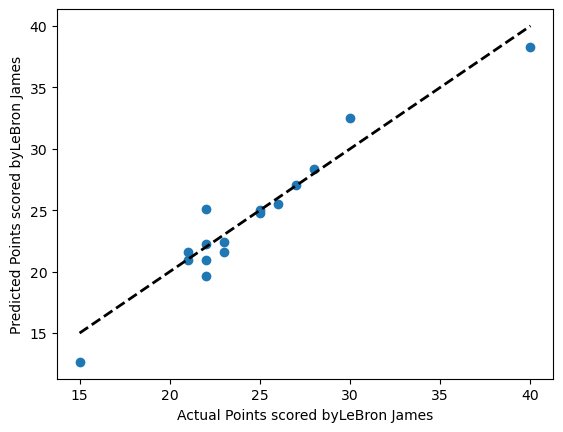

Mean Squared Error: 2.104648683180553
R-squared: 0.9227651859383283


In [41]:
test_prediction_model_2("LeBron James", players_2023, teams_2023, players_2023_playoffs, 
                       teams_2023_playoffs, point_prediction_2, point_prediction_2_test_data)

In [42]:
def test_prediction_model_1_mse(player_name, playersRegular_df, teamsRegular_df, playersPlayoff_df, teamsPlayoff_df, prediction_model, test_data):
    # create model
    model = prediction_model(player_name, playersRegular_df, teamsRegular_df)
    
    # extract playoff test data
    test_df = test_data(player_name, playersPlayoff_df, teamsPlayoff_df)
    
    # collect x and y test data. 
    # X is the data that we feed into the model. 
    # Y is the actual outcome to compare against the predicted values.
    x_test = test_df[['FGA', 'eFG%', 'FTA', 'FT_PCT', 'player/team']].fillna(0)
    y_test = np.array(test_df['PTS'])
    
    # Generate the predictions.
    y_pred = model.predict(x_test)
    
    #Calculate the Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

In [43]:
def test_prediction_model_1_r2(player_name, playersRegular_df, teamsRegular_df, playersPlayoff_df, teamsPlayoff_df, prediction_model, test_data):
    # create model
    model = prediction_model(player_name, playersRegular_df, teamsRegular_df)
    
    # extract playoff test data
    test_df = test_data(player_name, playersPlayoff_df, teamsPlayoff_df)
    
    # collect x and y test data. 
    # X is the data that we feed into the model. 
    # Y is the actual outcome to compare against the predicted values.
    x_test = test_df[['FGA', 'eFG%', 'FTA', 'FT_PCT', 'player/team']].fillna(0)
    y_test = np.array(test_df['PTS'])
    
    # Generate the predictions.
    y_pred = model.predict(x_test)
    
    #Calculate the R-Squared
    r2 = r2_score(y_test, y_pred)
    
    return r2

In [44]:
def test_prediction_model_2_mse(player_name, playersRegular_df, teamsRegular_df, playersPlayoff_df, teamsPlayoff_df, prediction_model, test_data):
    # create model
    model = prediction_model(player_name, playersRegular_df, teamsRegular_df)
    
    # extract playoff test data
    test_df = test_data(player_name, playersPlayoff_df, teamsPlayoff_df)
    
    # collect x and y test data. 
    # X is the data that we feed into the model. 
    # Y is the actual outcome to compare against the predicted values.
    x_test = test_df[['FGA', 'eFG%', 'FTA', 'FT_PCT', 'player/team', 'usageRate', 'MIN']].fillna(0)
    y_test = np.array(test_df['PTS'])
    
    # Generate the predictions.
    y_pred = model.predict(x_test)
    
    #Calculate the Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

In [45]:
def test_prediction_model_2_r2(player_name, playersRegular_df, teamsRegular_df, playersPlayoff_df, teamsPlayoff_df, prediction_model, test_data):
    # create model
    model = prediction_model(player_name, playersRegular_df, teamsRegular_df)
    
    # extract playoff test data
    test_df = test_data(player_name, playersPlayoff_df, teamsPlayoff_df)
    
    # collect x and y test data. 
    # X is the data that we feed into the model. 
    # Y is the actual outcome to compare against the predicted values.
    x_test = test_df[['FGA', 'eFG%', 'FTA', 'FT_PCT', 'player/team', 'usageRate', 'MIN']].fillna(0)
    y_test = np.array(test_df['PTS'])
    
    # Generate the predictions.
    y_pred = model.predict(x_test)


    #Calculate the R-Squared
    r2 = r2_score(y_test, y_pred)

    return r2

In [46]:
def compare_models(player_list):
    mse_list1 = []
    r2_list1 = []
    
    mse_list2 = []
    r2_list2 = []
    
    for player in player_list:
        mse1 = test_prediction_model_1_mse(player, players_2023, teams_2023, players_2023_playoffs, 
                       teams_2023_playoffs, point_prediction_1, point_prediction_1_test_data)
        r21 = test_prediction_model_1_r2(player, players_2023, teams_2023, players_2023_playoffs, 
                       teams_2023_playoffs, point_prediction_1, point_prediction_1_test_data)
        mse_list1.append(mse1)
        r2_list1.append(r21)
        
        
        mse2 = test_prediction_model_2_mse(player, players_2023, teams_2023, players_2023_playoffs, 
                       teams_2023_playoffs, point_prediction_2, point_prediction_2_test_data)
        r22 = test_prediction_model_2_r2(player, players_2023, teams_2023, players_2023_playoffs, 
                       teams_2023_playoffs, point_prediction_2, point_prediction_2_test_data)
        mse_list2.append(mse2)
        r2_list2.append(r22)
        
    print('Average of mse of model 1:', np.mean(mse_list1))
    print('Average of mse of model 2:', np.mean(mse_list2))
    print('Average of r2 of model 1:', np.mean(r2_list1))
    print('Average of r2 of model 2:', np.mean(r2_list2))

In [47]:
player_list = ["LeBron James"]

compare_models(player_list)

Average of mse of model 1: 2.6285186817028894
Average of mse of model 2: 2.104648683180553
Average of r2 of model 1: 0.9035405988365912
Average of r2 of model 2: 0.9227651859383283


In [48]:
def create_player_df(player_name, players_df, teams_df):
    #create player_df from players_df
    player_df = players_df[players_df['PLAYER_NAME'] == player_name].copy()
    
    # Split the 'MATCHUP' column by either 'vs.' or '@'
    split_matchup = player_df['MATCHUP'].str.split(' vs. | @ ')

    # Extract the second team abbreviation
    player_df['MATCHUP'] = split_matchup.apply(lambda x: x[1] if len(x) > 1 else None)
    
    #extract player game IDs
    player_game_ids = list(player_df['GAME_ID'])
    
    #extract team (opponent and team that player is on) data from games that player played in
    player_games = teams_df[teams_df['GAME_ID'].isin(player_game_ids)].copy()
    
    #extract team IDs of all the teams that the player was on during the season
    player_team_ids = set(list(player_df['TEAM_ID']))
    
    #create df of stats from the teams that the player played on only (not opposing teams' data)
    player_team_games = player_games[player_games['TEAM_ID'].isin(player_team_ids)].copy()
    
    #extract team fga from player_team_games
    team_fga = list(player_team_games['FGA'])
    
    #create a dictionary linking player_game_ids to team FGA
    game_id_team_fga_dict = {k:v for k,v in zip(player_game_ids, team_fga)}
    
    #map team_fga to player_df
    player_df.loc[:, 'team_fga'] = player_df['GAME_ID'].map(game_id_team_fga_dict)
    
    #calculate the percentage of the teams field goal attempts a player takes (FACTOR 1)
    player_df.loc[:, 'playerFGA%'] = player_df['FGA']/player_df['team_fga']
    
    #calculate the players eFG% (FACTOR 2)
    player_FGM = np.array(player_df['FGM'])
    player_ThreePM = np.array(player_df['FG3M'])
    player_FGA = np.array(player_df['FGA'])
    
    player_df.loc[:, 'eFG%'] = (player_FGM + (0.5 * player_ThreePM))/player_FGA
    
    team_points = list(player_team_games['PTS'])
    player_team_points_dict = {k:v for k,v in zip(player_game_ids, team_points)}

    player_df.loc[:, 'team_score'] = player_df['GAME_ID'].map(player_team_points_dict)
    player_df.loc[:, 'player/team'] = player_df['PTS']/player_df['team_score']
    
    player_df = player_df.loc[:, ['FGA', 'eFG%', 'FTA', 'FT_PCT', 'player/team', 'MATCHUP', 'PTS']]
    
    return player_df

In [49]:
# team_encoder = OneHotEncoder(sparse=False)
# player_df = create_player_df('LeBron James', players_2023, teams_2023)

In [50]:
# def nn_points_model(player_df):
    
#     team_encoder.fit(player_df['MATCHUP'].unique().reshape(-1,1))
    
#     team_encoded = team_encoder.transform(player_df['MATCHUP'].values.reshape(-1,1))

#     X = np.hstack((player_df[['FGA', 'eFG%', 'FTA', 'FT_PCT', 'player/team']].values, team_encoded)).astype(np.float32)
    
#     y = player_df['PTS'].values.astype(np.float32)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#     print(X_test[0])
#     nn_model = keras.Sequential([
#         keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
#         keras.layers.Dense(32, activation='relu'),
#         keras.layers.Dense(1)
#     ])

#     nn_model.compile(optimizer='adam', loss='mean_squared_error')

#     nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
#     return nn_model

In [51]:
#prediction_model = nn_points_model(player_df)

In [52]:
#prediction_model.predict()

In [53]:
# def test_nn_model(player_name, playersPlayoff_df, teamsPlayoff_df, model):
    
#     # extract playoff test data
#     test_df = create_player_df(player_name, playersPlayoff_df, teamsPlayoff_df)
    
#     team_encoded = team_encoder.transform(test_df['MATCHUP'].values.reshape(-1,1))
#     # collect x and y test data. 
#     # X is the data that we feed into the model. 
#     # Y is the actual outcome to compare against the predicted values.
#     x_test = np.hstack((test_df[['FGA', 'eFG%', 'FTA', 'FT_PCT', 'player/team']].values, team_encoded)).astype(np.float32)

#     y_test = test_df['PTS'].values.astype(np.float32)
    
#     # Generate the predictions.
#     y_pred = model.predict([x_test])
    
#     # Create a graph to visualize the results
#     plt.scatter(y_test, y_pred)
#     plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
#     plt.xlabel('Actual Points scored by' + player_name)
#     plt.ylabel('Predicted Points scored by' +  player_name)
#     plt.show()
    
#     # Find the Mean Squared Error (MSE)
#     loss = model.evaluate(x_test, y_test)
#     print("loss (MSE):", loss)

In [54]:
# test_nn_model('LeBron James', players_2023_playoffs, teams_2023_playoffs, prediction_model)

In [55]:
# def nn_predict_points(player_name, players_df, teams_df, opponent):
    
#     player_df = create_player_df(player_name, players_df, teams_df)

#     player_df = player_df[player_df['MATCHUP'] == opponent]
    
#     team_encoded = team_encoder.transform(player_df['MATCHUP'].values.reshape(-1,1))
#     stats = player_df[['FGA', 'eFG%', 'FTA', 'FT_PCT', 'player/team']]
#     avg_stats = stats.mean()
    
#     predictors = np.hstack((avg_stats.values, team_encoded[0])).astype(np.float32)
#     print(predictors)
#     return prediction_model.predict(predictors)

In [56]:
# nn_predict_points('LeBron James', players_2023, teams_2023, 'PHX')

In [57]:
def create_final_df(players_df, teams_df):
    
    # merge player and team dfs to combine player and team stats
    merge1 = pd.merge(players_df, teams_df, on=['TEAM_ID', 'GAME_ID'], how='inner')
    
    # Split the 'MATCHUP column by either 'vs.' or '@' to extract opponent team code
    split_matchup = merge1['MATCHUP_x'].str.split(' vs. | @ ')
    
    # Extract the opponent team abbreviation
    merge1['MATCHUP_x'] = split_matchup.apply(lambda x: x[1] if len(x) > 1 else None)
    
    # Rename the MATCHUP col to match with the opponent team_abbreviation col for second merge
    merge1.rename(columns={'MATCHUP_x':'TEAM_ABBREVIATION'}, inplace=True)
    
    # Final merge to collect individual player stats, the player's team's stats, and the opponent's stats
    final = pd.merge(merge1, teams_df, on=['TEAM_ABBREVIATION', 'GAME_ID'], how='inner')
    
    return final 

def prepare_data(final_df):
    # collect the specific input numerical and categorical data
    numerical_stats = final[['MIN_x', 'FGA_x', 'FG_PCT_x', 'FG3M_x', 'FG3A_x', 'FG3_PCT_x', 'FTM_x', 'FTA_x', 'FT_PCT_x', 'OREB_x', 'DREB_x', 'TOV_x', 'PF_x', 'PLUS_MINUS_x', 'PTS_y', 'FGM_y', 'FGA_y', 'FG_PCT_y', 'FG3M_y', 'FG3A_y', 'FG3_PCT_y', 'FTA_y', 'FT_PCT_y', 'OREB_y', 'DREB_y', 'REB_y', 'AST_y', 'STL_y', 'BLK_y', 'TOV_y', 'PF_y', 'PLUS_MINUS_y', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'PTS_x', 'REB_x', 'AST_x', 'STL_x', 'BLK_x']] 
    categorical_stats = final[['PLAYER_NAME', 'TEAM_ABBREVIATION_x', 'TEAM_ABBREVIATION']]
    
    # append the numerical and categorical inputs into lists for array formation
    num_data = []
    cat_data = []

    for x in range(0, len(numerical_stats)):
        num_data.append(list(numerical_stats.loc[x]))
        cat_data.append(list(categorical_stats.loc[x]))
        
    # make lists into numpy arrays and replace NaN values with 0s
    num_array = np.asarray(num_data).astype(float)
    num_array = np.nan_to_num(num_array, nan=0)

    cat_array = np.asarray(cat_data)
    cat_array = np.nan_to_num(cat_array, nan=0)
    
    # create dicts to map features in arrays to their index values
    features = ['PLAYER_NAME', 'TEAM_ABBREVIATION_x', 'TEAM_ABBREVIATION', 'MIN_x', 'PTS_x', 'FGA_x', 'FG_PCT_x', 'FG3M_x', 'FG3A_x', 'FG3_PCT_x', 'FTM_x', 'FTA_x', 'FT_PCT_x', 'OREB_x', 'DREB_x', 'TOV_x', 'PF_x', 'PLUS_MINUS_x', 'PTS_y', 'FGM_y', 'FGA_y', 'FG_PCT_y', 'FG3M_y', 'FG3A_y', 'FG3_PCT_y', 'FTA_y', 'FT_PCT_y', 'OREB_y', 'DREB_y', 'REB_y', 'AST_y', 'STL_y', 'BLK_y', 'TOV_y', 'PF_y', 'PLUS_MINUS_y', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'PTS_x', 'REB_x', 'AST_x', 'STL_x', 'BLK_x']
    feature_indicies = range(0, len(features))
    feature_dict = {k:v for k, v in zip(features,feature_indicies)}

    num_features = ['MIN_x', 'FGA_x', 'FG_PCT_x', 'FG3M_x', 'FG3A_x', 'FG3_PCT_x', 'FTM_x', 'FTA_x', 'FT_PCT_x', 'OREB_x', 'DREB_x', 'TOV_x', 'PF_x', 'PLUS_MINUS_x', 'PTS_y', 'FGM_y', 'FGA_y', 'FG_PCT_y', 'FG3M_y', 'FG3A_y', 'FG3_PCT_y', 'FTA_y', 'FT_PCT_y', 'OREB_y', 'DREB_y', 'REB_y', 'AST_y', 'STL_y', 'BLK_y', 'TOV_y', 'PF_y', 'PLUS_MINUS_y', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'PTS_x', 'REB_x', 'AST_x', 'STL_x', 'BLK_x']
    cat_features = ['PLAYER_NAME', 'TEAM_ABBREVIATION_x', 'TEAM_ABBREVIATION']

    num_feature_indicies = range(0, len(num_features))
    cat_feature_indicies = range(0, len(cat_features))

    num_feature_dict = {k:v for k, v in zip(num_features,num_feature_indicies)}
    cat_feature_dict = {k:v for k, v in zip(cat_features,cat_feature_indicies)}

    # create X (inputs) and y (outputs) numpy arrays
    X_num = num_array[:, [num_feature_dict['MIN_x'], num_feature_dict['FGA_x'], num_feature_dict['FG_PCT_x'], 
                     num_feature_dict['FG3M_x'], num_feature_dict['FG3A_x'], num_feature_dict['FG3_PCT_x'], 
                     num_feature_dict['OREB_x'], num_feature_dict['DREB_x'], num_feature_dict['TOV_x'], 
                     num_feature_dict['PF_x'], num_feature_dict['PLUS_MINUS_x'], num_feature_dict['PTS_y'], 
                     num_feature_dict['FGM_y'], num_feature_dict['FGA_y'], num_feature_dict['FG_PCT_y'], 
                     num_feature_dict['FG3M_y'], num_feature_dict['FG3A_y'], num_feature_dict['FG3_PCT_y'], 
                     num_feature_dict['FTA_y'], num_feature_dict['FT_PCT_y'], num_feature_dict['OREB_y'], 
                     num_feature_dict['DREB_y'], num_feature_dict['REB_y'], num_feature_dict['AST_y'], 
                     num_feature_dict['STL_y'], num_feature_dict['BLK_y'], num_feature_dict['TOV_y'], 
                     num_feature_dict['PF_y'], num_feature_dict['PLUS_MINUS_y'], num_feature_dict['PTS'], 
                     num_feature_dict['FGM'], num_feature_dict['FGA'], num_feature_dict['FG_PCT'], 
                     num_feature_dict['FG3M'], num_feature_dict['FG3A'], num_feature_dict['FG3_PCT'], 
                     num_feature_dict['FTM'], num_feature_dict['FTA'], num_feature_dict['FT_PCT'], 
                     num_feature_dict['OREB'], num_feature_dict['DREB'], num_feature_dict['REB'], 
                     num_feature_dict['AST'], num_feature_dict['STL'], num_feature_dict['BLK'], 
                     num_feature_dict['TOV'], num_feature_dict['PF'], num_feature_dict['PLUS_MINUS']]]

    X_cat = cat_array[:, [cat_feature_dict['PLAYER_NAME'], cat_feature_dict['TEAM_ABBREVIATION_x'], cat_feature_dict['TEAM_ABBREVIATION']]]

    y = num_array[:, 51:]

    return X_num, X_cat, y, num_feature_dict, cat_feature_dict, feature_dict



In [58]:
# 2022-2023 season data (last season)
final = create_final_df(players_2023, teams_2023)
X_num, X_cat, y, num_feature_dict, cat_feature_dict, feature_dict = prepare_data(final)

# 2023-2023 season data (current season)
final_2024 = create_final_df(players_2024, teams_2024)
X_num_2024, X_cat_2024, y_2024, num_feature_dict, cat_feature_dict, feature_dict = prepare_data(final_2024)



In [59]:
# Initialize LabelEncoders for each categorical feature
player_name_encoder = LabelEncoder()
team_encoder = LabelEncoder()

# Concatenate data
all_player_names = np.concatenate([X_cat[:, cat_feature_dict['PLAYER_NAME']], X_cat_2024[:, cat_feature_dict['PLAYER_NAME']]])
all_player_teams = np.concatenate([X_cat[:, cat_feature_dict['TEAM_ABBREVIATION_x']], X_cat_2024[:, cat_feature_dict['TEAM_ABBREVIATION_x']]])
all_opponent_teams = np.concatenate([X_cat[:, cat_feature_dict['TEAM_ABBREVIATION']], X_cat_2024[:, cat_feature_dict['TEAM_ABBREVIATION']]])

# fit the encoders on the concatenated data
player_name_encoder.fit(all_player_names)
team_encoder.fit(all_player_teams)
team_encoder.fit(all_opponent_teams)

LabelEncoder()

In [60]:
def split_train_test_data(X_cat, X_num, y):
    # transform the categorical variables in dataset
    X_cat[:, cat_feature_dict['PLAYER_NAME']] = player_name_encoder.fit_transform(X_cat[:, cat_feature_dict['PLAYER_NAME']]).astype(int)
    X_cat[:, cat_feature_dict['TEAM_ABBREVIATION_x']] = team_encoder.fit_transform(X_cat[:, cat_feature_dict['TEAM_ABBREVIATION_x']]).astype(int)
    X_cat[:, cat_feature_dict['TEAM_ABBREVIATION']] = team_encoder.fit_transform(X_cat[:, cat_feature_dict['TEAM_ABBREVIATION']]).astype(int)
    
    # Cast numerical data to type float
    X_cat = X_cat.astype(float)
    X_num = X_num.astype(float)
    
    # combine cateogrical and numerical data into one X input
    X = np.hstack((X_cat, X_num))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [61]:
X_train, X_test, y_train, y_test = split_train_test_data(X_cat, X_num, y)



In [62]:
X_train_2024, X_test_2024, y_train_2024, y_test_2024 = split_train_test_data(X_cat_2024, X_num_2024, y_2024)



In [63]:
# set up the model architecture

# normalize the numeric data
normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=None)
normalizer.adapt(X_train[:, 3:])

# create the input layer

# input for the player name
input_player_name = Input(shape=(1,), name='input_player_name')

# input for the player team
input_player_team = Input(shape=(1,), name='input_player_team')

# input for the opponent team
input_opponent_team = Input(shape=(1,), name='input_opponent_team')

# input for the rest of the numeric data
input_features = Input(shape=(X_train.shape[1] - 3,), name='input_features')

# normalized layer of the input features
norm = normalizer(input_features)

# create embedding layer for the categorical inputs

# hyperparameter: embedding dim
embedding_dim = 8

# embedding variable for player name
embedding_player_name = Embedding(input_dim=np.max(X_train[:, feature_dict['PLAYER_NAME']].astype(int)) + 1, output_dim=embedding_dim)(input_player_name)

# embedding variable for player team
embedding_player_team = Embedding(input_dim=np.max(X_train[:, feature_dict['TEAM_ABBREVIATION_x']].astype(int)) + 1, output_dim=embedding_dim)(input_player_team)

# embedding variable for opponent team
embedding_opponent_team = Embedding(input_dim=np.max(X_train[:, feature_dict['TEAM_ABBREVIATION']].astype(int)) + 1, output_dim=embedding_dim)(input_opponent_team)

# flatten embedding layer
embedding_player_name = Flatten()(embedding_player_name)
embedding_player_team = Flatten()(embedding_player_team)
embedding_opponent_team = Flatten()(embedding_opponent_team)

# concatenate all of the input layers
concatenated = concatenate([embedding_player_name, embedding_player_team, embedding_opponent_team, norm])

# create hidden layers to capture complexity of data relationships
# hyperparameter: neuron count in each layer, here 64 in the first and 32 in the second
hidden_layer_1 = Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01))(concatenated)
hidden_layer_2 = Dense(32, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01))(hidden_layer_1)

# adding dropout layers after dense layers, hyperparameter: dropout rate
hidden_layer_1 = Dropout(0.3)(hidden_layer_1)
hidden_layer_2 = Dropout(0.3)(hidden_layer_2)

# add batch normalization
hidden_layer_1 = BatchNormalization()(hidden_layer_1)
hidden_layer_2 = BatchNormalization()(hidden_layer_2)

# create output layers for points, rebounds, assists, steals, and blocks
output_points = Dense(1, activation='linear', name='output_points')(hidden_layer_2)
output_rebounds = Dense(1, activation='linear', name='output_rebounds')(hidden_layer_2)
output_assists = Dense(1, activation='linear', name='output_assists')(hidden_layer_2)
output_steals = Dense(1, activation='linear', name='output_steals')(hidden_layer_2)
output_blocks = Dense(1, activation='linear', name='output_blocks')(hidden_layer_2)

# initialize model with inputs and outputs
model = Model(inputs=[input_player_name, input_player_team, input_opponent_team, input_features],
             outputs=[output_points, output_rebounds, output_assists, output_steals, output_blocks])



2023-11-02 18:23:50.922512: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-02 18:23:50.922537: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-02 18:23:50.922542: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-02 18:23:50.922572: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-02 18:23:50.922587: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-02 18:23:51.031708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 18:23:51.046330:

In [64]:
# create learning curve plot with early stopping if loss increases substantially during training
class LearningCurveCallback(tf.keras.callbacks.Callback):
    def __init__(self, patience=10):
        super(LearningCurveCallback, self).__init__()
        self.patience = patience
        self.best_val_loss = float('inf')
        self.wait = 0

    def on_train_begin(self, logs=None):
        self.history = {'loss': [], 'val_loss': []}

    def on_epoch_end(self, epoch, logs=None):
        self.history['loss'].append(logs['loss'])
        self.history['val_loss'].append(logs['val_loss'])

        plt.plot(self.history['loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Learning Curve')
        plt.show()

        if logs['val_loss'] < self.best_val_loss:
            self.best_val_loss = logs['val_loss']
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print(f"Early stopping at epoch {self.stopped_epoch}")

Epoch 1/25


2023-11-02 18:23:54.074696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 18:23:54.211207: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


346/346 [==============================] - ETA: 0s - loss: 161.1868 - output_points_loss: 128.1429 - output_rebounds_loss: 18.7832 - output_assists_loss: 10.0811 - output_steals_loss: 1.9259 - output_blocks_loss: 1.4435 - output_points_mae: 8.9850 - output_rebounds_mae: 3.3333 - output_assists_mae: 2.2981 - output_steals_mae: 1.0334 - output_blocks_mae: 0.8912

2023-11-02 18:24:09.957842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


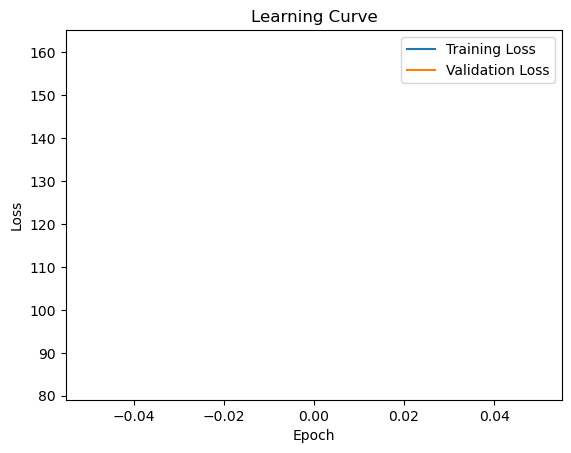

346/346 [==============================] - 18s 47ms/step - loss: 161.1868 - output_points_loss: 128.1429 - output_rebounds_loss: 18.7832 - output_assists_loss: 10.0811 - output_steals_loss: 1.9259 - output_blocks_loss: 1.4435 - output_points_mae: 8.9850 - output_rebounds_mae: 3.3333 - output_assists_mae: 2.2981 - output_steals_mae: 1.0334 - output_blocks_mae: 0.8912 - val_loss: 82.9931 - val_output_points_loss: 59.4881 - val_output_rebounds_loss: 16.3047 - val_output_assists_loss: 4.8189 - val_output_steals_loss: 0.8002 - val_output_blocks_loss: 0.8466 - val_output_points_mae: 6.4443 - val_output_rebounds_mae: 3.3039 - val_output_assists_mae: 1.5349 - val_output_steals_mae: 0.6570 - val_output_blocks_mae: 0.5937
Epoch 2/25
346/346 [==============================] - ETA: 0s - loss: 41.2973 - output_points_loss: 27.0399 - output_rebounds_loss: 6.7935 - output_assists_loss: 5.2140 - output_steals_loss: 0.8562 - output_blocks_loss: 0.6619 - output_points_mae: 3.9368 - output_rebounds_mae: 

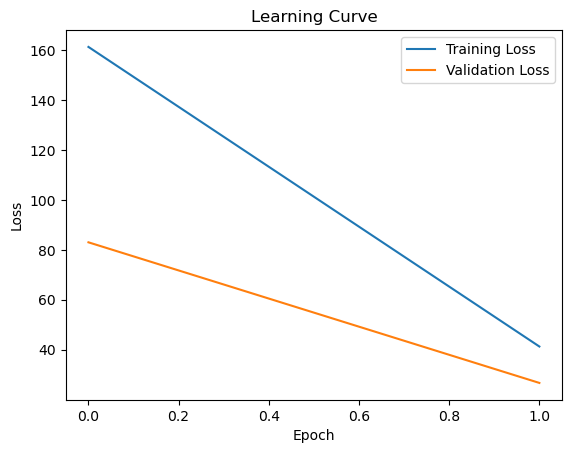

346/346 [==============================] - 16s 45ms/step - loss: 41.2973 - output_points_loss: 27.0399 - output_rebounds_loss: 6.7935 - output_assists_loss: 5.2140 - output_steals_loss: 0.8562 - output_blocks_loss: 0.6619 - output_points_mae: 3.9368 - output_rebounds_mae: 1.9768 - output_assists_mae: 1.6732 - output_steals_mae: 0.7055 - output_blocks_mae: 0.5816 - val_loss: 26.7259 - val_output_points_loss: 15.1380 - val_output_rebounds_loss: 4.8328 - val_output_assists_loss: 4.6156 - val_output_steals_loss: 0.8236 - val_output_blocks_loss: 0.5729 - val_output_points_mae: 3.0671 - val_output_rebounds_mae: 1.6137 - val_output_assists_mae: 1.5360 - val_output_steals_mae: 0.7306 - val_output_blocks_mae: 0.5655
Epoch 3/25
346/346 [==============================] - ETA: 0s - loss: 31.0311 - output_points_loss: 19.3568 - output_rebounds_loss: 4.6067 - output_assists_loss: 4.8829 - output_steals_loss: 0.8008 - output_blocks_loss: 0.6109 - output_points_mae: 3.3640 - output_rebounds_mae: 1.623

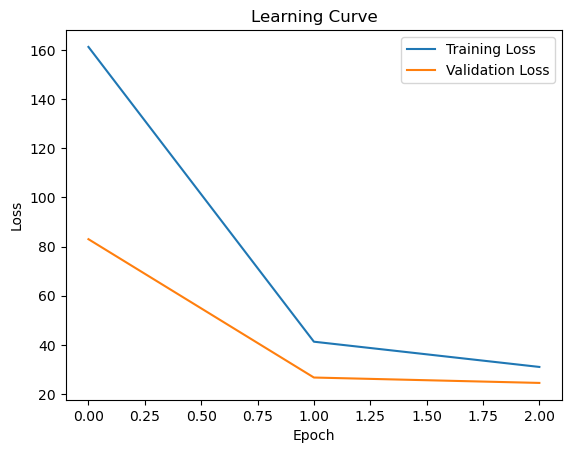

346/346 [==============================] - 16s 45ms/step - loss: 31.0311 - output_points_loss: 19.3568 - output_rebounds_loss: 4.6067 - output_assists_loss: 4.8829 - output_steals_loss: 0.8008 - output_blocks_loss: 0.6109 - output_points_mae: 3.3640 - output_rebounds_mae: 1.6234 - output_assists_mae: 1.6036 - output_steals_mae: 0.6863 - output_blocks_mae: 0.5596 - val_loss: 24.5319 - val_output_points_loss: 14.9833 - val_output_rebounds_loss: 2.8034 - val_output_assists_loss: 4.5951 - val_output_steals_loss: 0.7918 - val_output_blocks_loss: 0.5569 - val_output_points_mae: 2.9927 - val_output_rebounds_mae: 1.2193 - val_output_assists_mae: 1.5556 - val_output_steals_mae: 0.7009 - val_output_blocks_mae: 0.5495
Epoch 4/25
346/346 [==============================] - ETA: 0s - loss: 28.5978 - output_points_loss: 18.0773 - output_rebounds_loss: 3.4974 - output_assists_loss: 4.8134 - output_steals_loss: 0.7970 - output_blocks_loss: 0.6016 - output_points_mae: 3.2302 - output_rebounds_mae: 1.398

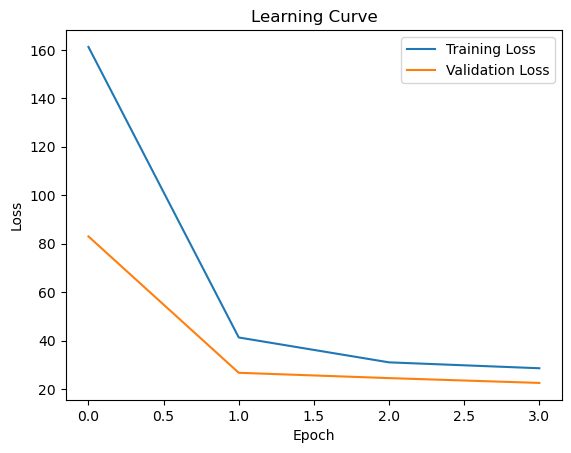

346/346 [==============================] - 15s 45ms/step - loss: 28.5978 - output_points_loss: 18.0773 - output_rebounds_loss: 3.4974 - output_assists_loss: 4.8134 - output_steals_loss: 0.7970 - output_blocks_loss: 0.6016 - output_points_mae: 3.2302 - output_rebounds_mae: 1.3982 - output_assists_mae: 1.5830 - output_steals_mae: 0.6863 - output_blocks_mae: 0.5561 - val_loss: 22.5450 - val_output_points_loss: 13.8851 - val_output_rebounds_loss: 1.8993 - val_output_assists_loss: 4.5782 - val_output_steals_loss: 0.7892 - val_output_blocks_loss: 0.5617 - val_output_points_mae: 2.8748 - val_output_rebounds_mae: 1.0953 - val_output_assists_mae: 1.5410 - val_output_steals_mae: 0.6857 - val_output_blocks_mae: 0.5147
Epoch 5/25
346/346 [==============================] - ETA: 0s - loss: 27.3104 - output_points_loss: 17.3937 - output_rebounds_loss: 2.9160 - output_assists_loss: 4.7479 - output_steals_loss: 0.7859 - output_blocks_loss: 0.6038 - output_points_mae: 3.1947 - output_rebounds_mae: 1.262

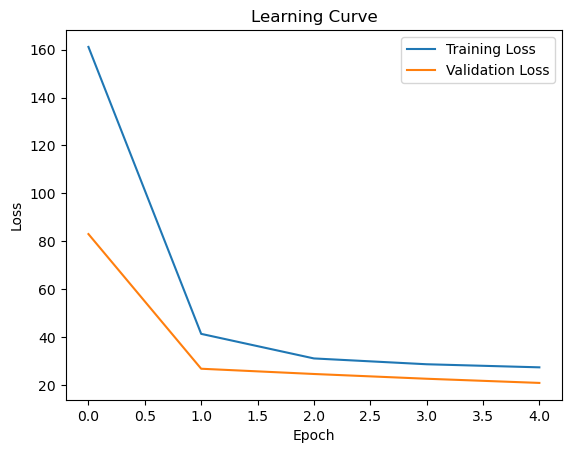

346/346 [==============================] - 15s 44ms/step - loss: 27.3104 - output_points_loss: 17.3937 - output_rebounds_loss: 2.9160 - output_assists_loss: 4.7479 - output_steals_loss: 0.7859 - output_blocks_loss: 0.6038 - output_points_mae: 3.1947 - output_rebounds_mae: 1.2622 - output_assists_mae: 1.5760 - output_steals_mae: 0.6800 - output_blocks_mae: 0.5553 - val_loss: 20.7988 - val_output_points_loss: 12.6691 - val_output_rebounds_loss: 1.3743 - val_output_assists_loss: 4.5100 - val_output_steals_loss: 0.7884 - val_output_blocks_loss: 0.5598 - val_output_points_mae: 2.7355 - val_output_rebounds_mae: 0.9093 - val_output_assists_mae: 1.5467 - val_output_steals_mae: 0.7001 - val_output_blocks_mae: 0.5546
Epoch 6/25
345/346 [============================>.] - ETA: 0s - loss: 25.9763 - output_points_loss: 16.3409 - output_rebounds_loss: 2.6831 - output_assists_loss: 4.6288 - output_steals_loss: 0.7891 - output_blocks_loss: 0.6040 - output_points_mae: 3.0799 - output_rebounds_mae: 1.189

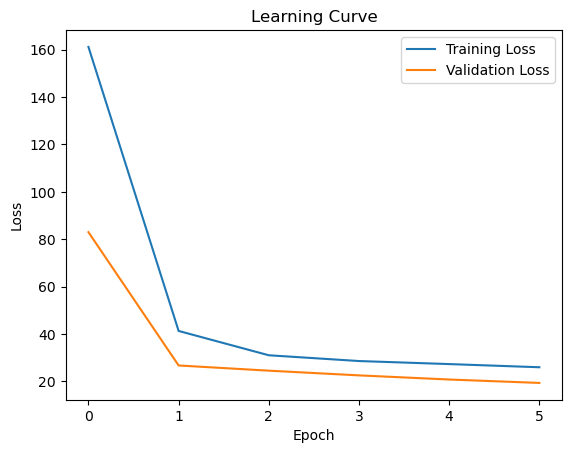

346/346 [==============================] - 15s 43ms/step - loss: 25.9748 - output_points_loss: 16.3419 - output_rebounds_loss: 2.6823 - output_assists_loss: 4.6272 - output_steals_loss: 0.7891 - output_blocks_loss: 0.6038 - output_points_mae: 3.0802 - output_rebounds_mae: 1.1895 - output_assists_mae: 1.5506 - output_steals_mae: 0.6816 - output_blocks_mae: 0.5563 - val_loss: 19.3597 - val_output_points_loss: 11.5453 - val_output_rebounds_loss: 1.0895 - val_output_assists_loss: 4.4201 - val_output_steals_loss: 0.7837 - val_output_blocks_loss: 0.5585 - val_output_points_mae: 2.6036 - val_output_rebounds_mae: 0.8029 - val_output_assists_mae: 1.4854 - val_output_steals_mae: 0.6688 - val_output_blocks_mae: 0.5436
Epoch 7/25
346/346 [==============================] - ETA: 0s - loss: 25.8041 - output_points_loss: 16.4280 - output_rebounds_loss: 2.4274 - output_assists_loss: 4.5476 - output_steals_loss: 0.7903 - output_blocks_loss: 0.6052 - output_points_mae: 3.0854 - output_rebounds_mae: 1.116

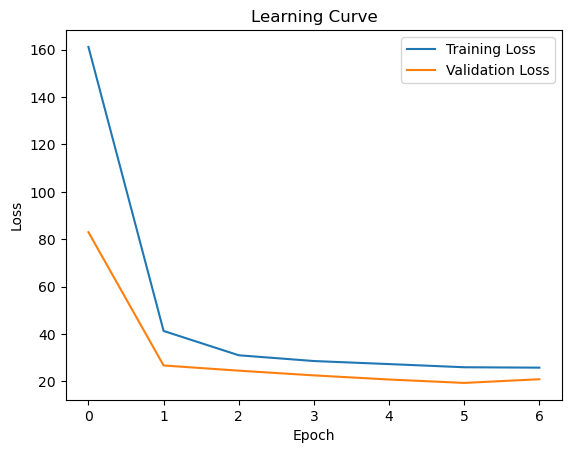

346/346 [==============================] - 15s 44ms/step - loss: 25.8041 - output_points_loss: 16.4280 - output_rebounds_loss: 2.4274 - output_assists_loss: 4.5476 - output_steals_loss: 0.7903 - output_blocks_loss: 0.6052 - output_points_mae: 3.0854 - output_rebounds_mae: 1.1167 - output_assists_mae: 1.5484 - output_steals_mae: 0.6829 - output_blocks_mae: 0.5571 - val_loss: 20.9207 - val_output_points_loss: 12.6737 - val_output_rebounds_loss: 1.5601 - val_output_assists_loss: 4.2950 - val_output_steals_loss: 0.7895 - val_output_blocks_loss: 0.5675 - val_output_points_mae: 2.7484 - val_output_rebounds_mae: 0.9310 - val_output_assists_mae: 1.4751 - val_output_steals_mae: 0.7029 - val_output_blocks_mae: 0.5207
Epoch 8/25
346/346 [==============================] - ETA: 0s - loss: 25.0467 - output_points_loss: 15.7469 - output_rebounds_loss: 2.3784 - output_assists_loss: 4.4548 - output_steals_loss: 0.7902 - output_blocks_loss: 0.6106 - output_points_mae: 3.0252 - output_rebounds_mae: 1.088

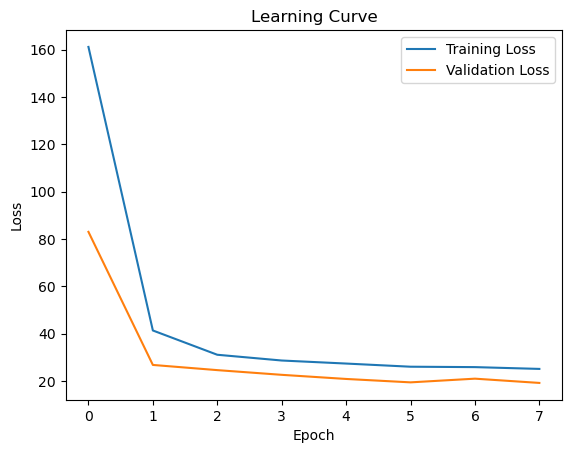

346/346 [==============================] - 15s 45ms/step - loss: 25.0467 - output_points_loss: 15.7469 - output_rebounds_loss: 2.3784 - output_assists_loss: 4.4548 - output_steals_loss: 0.7902 - output_blocks_loss: 0.6106 - output_points_mae: 3.0252 - output_rebounds_mae: 1.0882 - output_assists_mae: 1.5428 - output_steals_mae: 0.6838 - output_blocks_mae: 0.5599 - val_loss: 19.1217 - val_output_points_loss: 11.6870 - val_output_rebounds_loss: 0.7188 - val_output_assists_loss: 4.2656 - val_output_steals_loss: 0.7864 - val_output_blocks_loss: 0.5702 - val_output_points_mae: 2.5952 - val_output_rebounds_mae: 0.6329 - val_output_assists_mae: 1.4610 - val_output_steals_mae: 0.6774 - val_output_blocks_mae: 0.5706
Epoch 9/25
346/346 [==============================] - ETA: 0s - loss: 24.5606 - output_points_loss: 15.3769 - output_rebounds_loss: 2.2417 - output_assists_loss: 4.4187 - output_steals_loss: 0.7920 - output_blocks_loss: 0.6103 - output_points_mae: 2.9828 - output_rebounds_mae: 1.044

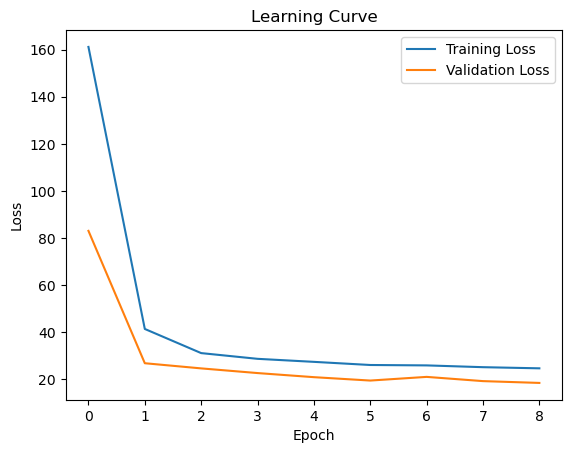

346/346 [==============================] - 15s 44ms/step - loss: 24.5606 - output_points_loss: 15.3769 - output_rebounds_loss: 2.2417 - output_assists_loss: 4.4187 - output_steals_loss: 0.7920 - output_blocks_loss: 0.6103 - output_points_mae: 2.9828 - output_rebounds_mae: 1.0448 - output_assists_mae: 1.5372 - output_steals_mae: 0.6858 - output_blocks_mae: 0.5613 - val_loss: 18.3549 - val_output_points_loss: 10.9691 - val_output_rebounds_loss: 0.7856 - val_output_assists_loss: 4.0971 - val_output_steals_loss: 0.7893 - val_output_blocks_loss: 0.5668 - val_output_points_mae: 2.5400 - val_output_rebounds_mae: 0.6329 - val_output_assists_mae: 1.4455 - val_output_steals_mae: 0.6953 - val_output_blocks_mae: 0.5421
Epoch 10/25
345/346 [============================>.] - ETA: 0s - loss: 24.5913 - output_points_loss: 15.5809 - output_rebounds_loss: 2.1694 - output_assists_loss: 4.2657 - output_steals_loss: 0.7888 - output_blocks_loss: 0.6093 - output_points_mae: 3.0075 - output_rebounds_mae: 1.02

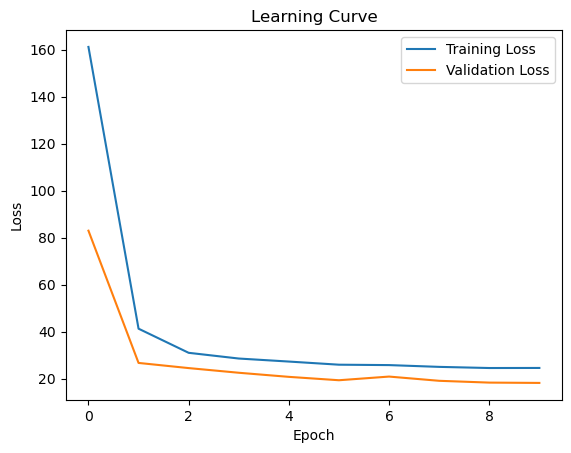

346/346 [==============================] - 15s 43ms/step - loss: 24.5886 - output_points_loss: 15.5795 - output_rebounds_loss: 2.1691 - output_assists_loss: 4.2647 - output_steals_loss: 0.7888 - output_blocks_loss: 0.6093 - output_points_mae: 3.0077 - output_rebounds_mae: 1.0288 - output_assists_mae: 1.5129 - output_steals_mae: 0.6821 - output_blocks_mae: 0.5601 - val_loss: 18.2194 - val_output_points_loss: 11.1357 - val_output_rebounds_loss: 0.6308 - val_output_assists_loss: 3.8833 - val_output_steals_loss: 0.7918 - val_output_blocks_loss: 0.5682 - val_output_points_mae: 2.5110 - val_output_rebounds_mae: 0.6315 - val_output_assists_mae: 1.4418 - val_output_steals_mae: 0.7073 - val_output_blocks_mae: 0.5477
Epoch 11/25
346/346 [==============================] - ETA: 0s - loss: 24.1924 - output_points_loss: 15.2142 - output_rebounds_loss: 2.2021 - output_assists_loss: 4.1280 - output_steals_loss: 0.7911 - output_blocks_loss: 0.6094 - output_points_mae: 2.9831 - output_rebounds_mae: 1.03

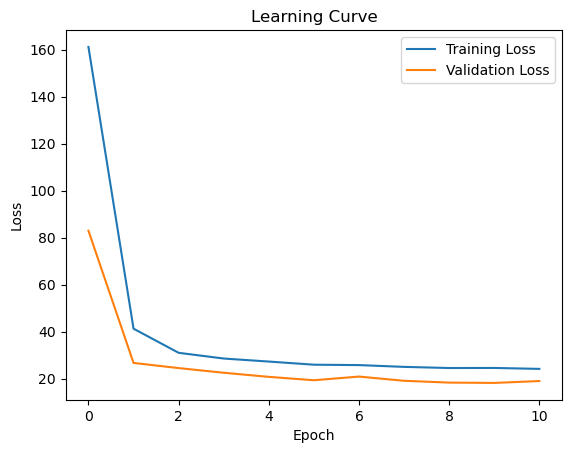

346/346 [==============================] - 15s 43ms/step - loss: 24.1924 - output_points_loss: 15.2142 - output_rebounds_loss: 2.2021 - output_assists_loss: 4.1280 - output_steals_loss: 0.7911 - output_blocks_loss: 0.6094 - output_points_mae: 2.9831 - output_rebounds_mae: 1.0345 - output_assists_mae: 1.4986 - output_steals_mae: 0.6848 - output_blocks_mae: 0.5614 - val_loss: 19.0150 - val_output_points_loss: 11.0857 - val_output_rebounds_loss: 1.5614 - val_output_assists_loss: 3.7315 - val_output_steals_loss: 0.7816 - val_output_blocks_loss: 0.5701 - val_output_points_mae: 2.5376 - val_output_rebounds_mae: 1.1072 - val_output_assists_mae: 1.4039 - val_output_steals_mae: 0.6831 - val_output_blocks_mae: 0.5766
Epoch 12/25
345/346 [============================>.] - ETA: 0s - loss: 23.7400 - output_points_loss: 14.7795 - output_rebounds_loss: 2.2091 - output_assists_loss: 4.0349 - output_steals_loss: 0.7887 - output_blocks_loss: 0.6082 - output_points_mae: 2.9243 - output_rebounds_mae: 1.03

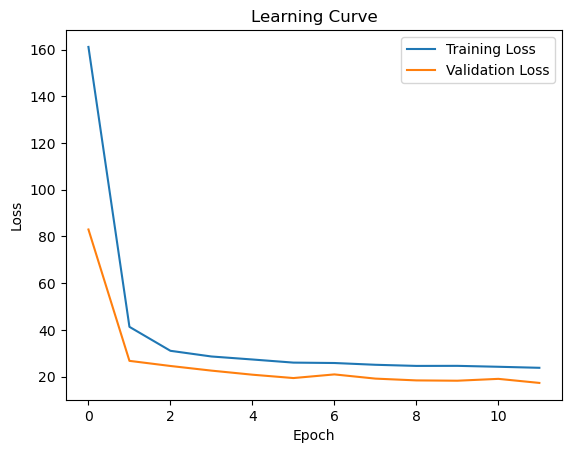

346/346 [==============================] - 15s 44ms/step - loss: 23.7508 - output_points_loss: 14.7908 - output_rebounds_loss: 2.2085 - output_assists_loss: 4.0352 - output_steals_loss: 0.7886 - output_blocks_loss: 0.6079 - output_points_mae: 2.9256 - output_rebounds_mae: 1.0307 - output_assists_mae: 1.4798 - output_steals_mae: 0.6824 - output_blocks_mae: 0.5603 - val_loss: 17.2755 - val_output_points_loss: 9.4710 - val_output_rebounds_loss: 0.9731 - val_output_assists_loss: 4.1117 - val_output_steals_loss: 0.7925 - val_output_blocks_loss: 0.5730 - val_output_points_mae: 2.3036 - val_output_rebounds_mae: 0.8553 - val_output_assists_mae: 1.4293 - val_output_steals_mae: 0.6638 - val_output_blocks_mae: 0.5816
Epoch 13/25
345/346 [============================>.] - ETA: 0s - loss: 23.5120 - output_points_loss: 14.7304 - output_rebounds_loss: 2.0708 - output_assists_loss: 3.9245 - output_steals_loss: 0.7872 - output_blocks_loss: 0.6114 - output_points_mae: 2.9166 - output_rebounds_mae: 0.996

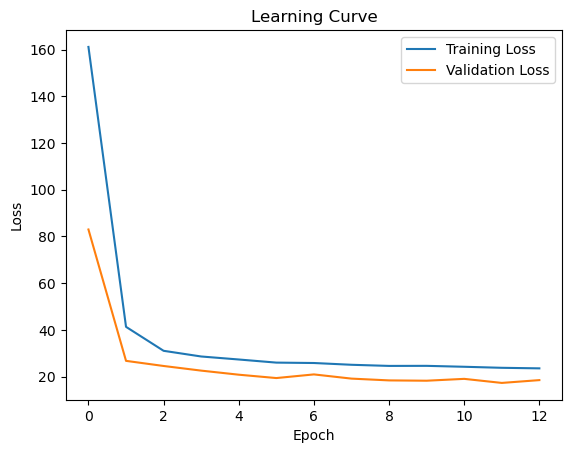

346/346 [==============================] - 15s 43ms/step - loss: 23.5141 - output_points_loss: 14.7334 - output_rebounds_loss: 2.0701 - output_assists_loss: 3.9249 - output_steals_loss: 0.7870 - output_blocks_loss: 0.6111 - output_points_mae: 2.9170 - output_rebounds_mae: 0.9959 - output_assists_mae: 1.4632 - output_steals_mae: 0.6831 - output_blocks_mae: 0.5633 - val_loss: 18.4770 - val_output_points_loss: 11.3416 - val_output_rebounds_loss: 0.7456 - val_output_assists_loss: 3.6210 - val_output_steals_loss: 0.7834 - val_output_blocks_loss: 0.5697 - val_output_points_mae: 2.5994 - val_output_rebounds_mae: 0.7285 - val_output_assists_mae: 1.3449 - val_output_steals_mae: 0.6868 - val_output_blocks_mae: 0.5607
Epoch 14/25
346/346 [==============================] - ETA: 0s - loss: 23.0740 - output_points_loss: 14.3252 - output_rebounds_loss: 2.1109 - output_assists_loss: 3.7899 - output_steals_loss: 0.7866 - output_blocks_loss: 0.6090 - output_points_mae: 2.8799 - output_rebounds_mae: 1.00

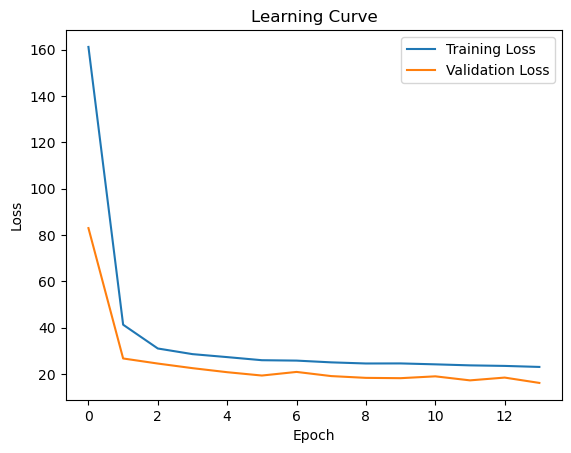

346/346 [==============================] - 16s 45ms/step - loss: 23.0740 - output_points_loss: 14.3252 - output_rebounds_loss: 2.1109 - output_assists_loss: 3.7899 - output_steals_loss: 0.7866 - output_blocks_loss: 0.6090 - output_points_mae: 2.8799 - output_rebounds_mae: 1.0013 - output_assists_mae: 1.4316 - output_steals_mae: 0.6832 - output_blocks_mae: 0.5595 - val_loss: 16.1727 - val_output_points_loss: 9.4818 - val_output_rebounds_loss: 0.4821 - val_output_assists_loss: 3.3686 - val_output_steals_loss: 0.7842 - val_output_blocks_loss: 0.5679 - val_output_points_mae: 2.3529 - val_output_rebounds_mae: 0.5417 - val_output_assists_mae: 1.3723 - val_output_steals_mae: 0.6972 - val_output_blocks_mae: 0.5486
Epoch 15/25
346/346 [==============================] - ETA: 0s - loss: 23.5664 - output_points_loss: 14.8326 - output_rebounds_loss: 2.0961 - output_assists_loss: 3.7151 - output_steals_loss: 0.7869 - output_blocks_loss: 0.6126 - output_points_mae: 2.9143 - output_rebounds_mae: 1.007

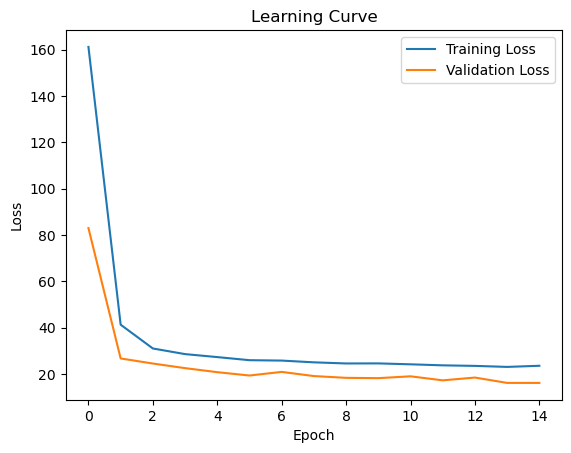

346/346 [==============================] - 15s 44ms/step - loss: 23.5664 - output_points_loss: 14.8326 - output_rebounds_loss: 2.0961 - output_assists_loss: 3.7151 - output_steals_loss: 0.7869 - output_blocks_loss: 0.6126 - output_points_mae: 2.9143 - output_rebounds_mae: 1.0072 - output_assists_mae: 1.4255 - output_steals_mae: 0.6822 - output_blocks_mae: 0.5633 - val_loss: 16.1627 - val_output_points_loss: 9.4015 - val_output_rebounds_loss: 0.5439 - val_output_assists_loss: 3.3037 - val_output_steals_loss: 0.7946 - val_output_blocks_loss: 0.5656 - val_output_points_mae: 2.3017 - val_output_rebounds_mae: 0.5783 - val_output_assists_mae: 1.3593 - val_output_steals_mae: 0.7063 - val_output_blocks_mae: 0.5540
Epoch 16/25
346/346 [==============================] - ETA: 0s - loss: 23.1855 - output_points_loss: 14.3220 - output_rebounds_loss: 2.2027 - output_assists_loss: 3.6791 - output_steals_loss: 0.7842 - output_blocks_loss: 0.6101 - output_points_mae: 2.8803 - output_rebounds_mae: 1.022

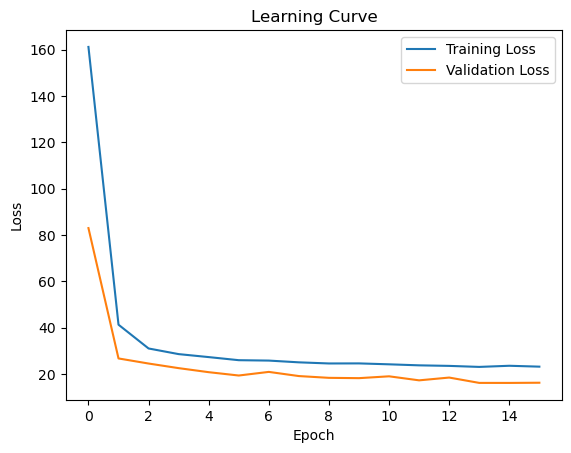

346/346 [==============================] - 15s 45ms/step - loss: 23.1855 - output_points_loss: 14.3220 - output_rebounds_loss: 2.2027 - output_assists_loss: 3.6791 - output_steals_loss: 0.7842 - output_blocks_loss: 0.6101 - output_points_mae: 2.8803 - output_rebounds_mae: 1.0226 - output_assists_mae: 1.4206 - output_steals_mae: 0.6832 - output_blocks_mae: 0.5636 - val_loss: 16.2449 - val_output_points_loss: 9.4090 - val_output_rebounds_loss: 0.6267 - val_output_assists_loss: 3.2319 - val_output_steals_loss: 0.7826 - val_output_blocks_loss: 0.5701 - val_output_points_mae: 2.3421 - val_output_rebounds_mae: 0.5528 - val_output_assists_mae: 1.3385 - val_output_steals_mae: 0.6889 - val_output_blocks_mae: 0.5356
Epoch 17/25
346/346 [==============================] - ETA: 0s - loss: 23.2486 - output_points_loss: 14.4066 - output_rebounds_loss: 2.1512 - output_assists_loss: 3.6299 - output_steals_loss: 0.7860 - output_blocks_loss: 0.6099 - output_points_mae: 2.8887 - output_rebounds_mae: 1.009

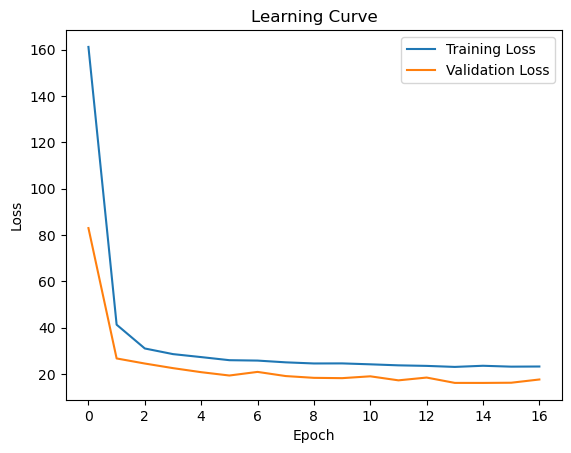

346/346 [==============================] - 16s 46ms/step - loss: 23.2486 - output_points_loss: 14.4066 - output_rebounds_loss: 2.1512 - output_assists_loss: 3.6299 - output_steals_loss: 0.7860 - output_blocks_loss: 0.6099 - output_points_mae: 2.8887 - output_rebounds_mae: 1.0092 - output_assists_mae: 1.4070 - output_steals_mae: 0.6817 - output_blocks_mae: 0.5610 - val_loss: 17.6451 - val_output_points_loss: 10.8287 - val_output_rebounds_loss: 0.5394 - val_output_assists_loss: 3.2140 - val_output_steals_loss: 0.7901 - val_output_blocks_loss: 0.5643 - val_output_points_mae: 2.5803 - val_output_rebounds_mae: 0.5631 - val_output_assists_mae: 1.3393 - val_output_steals_mae: 0.6995 - val_output_blocks_mae: 0.5530
Epoch 18/25
346/346 [==============================] - ETA: 0s - loss: 23.3842 - output_points_loss: 14.4425 - output_rebounds_loss: 2.2121 - output_assists_loss: 3.5880 - output_steals_loss: 0.7845 - output_blocks_loss: 0.6108 - output_points_mae: 2.8931 - output_rebounds_mae: 1.03

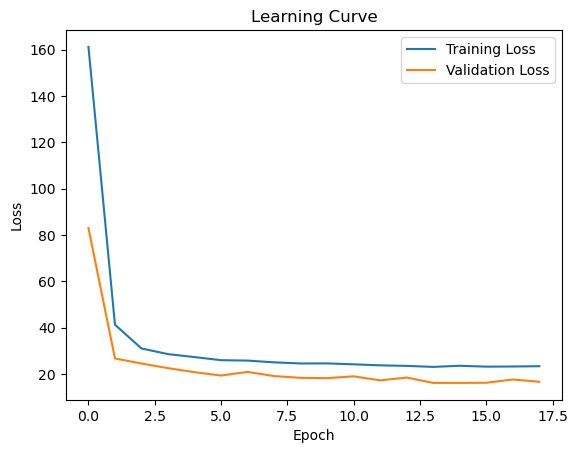

346/346 [==============================] - 15s 43ms/step - loss: 23.3842 - output_points_loss: 14.4425 - output_rebounds_loss: 2.2121 - output_assists_loss: 3.5880 - output_steals_loss: 0.7845 - output_blocks_loss: 0.6108 - output_points_mae: 2.8931 - output_rebounds_mae: 1.0334 - output_assists_mae: 1.4042 - output_steals_mae: 0.6818 - output_blocks_mae: 0.5598 - val_loss: 16.6503 - val_output_points_loss: 9.6718 - val_output_rebounds_loss: 0.6831 - val_output_assists_loss: 3.1566 - val_output_steals_loss: 0.7890 - val_output_blocks_loss: 0.5640 - val_output_points_mae: 2.3649 - val_output_rebounds_mae: 0.5728 - val_output_assists_mae: 1.3406 - val_output_steals_mae: 0.7020 - val_output_blocks_mae: 0.5441
Epoch 19/25
345/346 [============================>.] - ETA: 0s - loss: 23.2502 - output_points_loss: 14.2948 - output_rebounds_loss: 2.1724 - output_assists_loss: 3.5652 - output_steals_loss: 0.7852 - output_blocks_loss: 0.6085 - output_points_mae: 2.8871 - output_rebounds_mae: 1.007

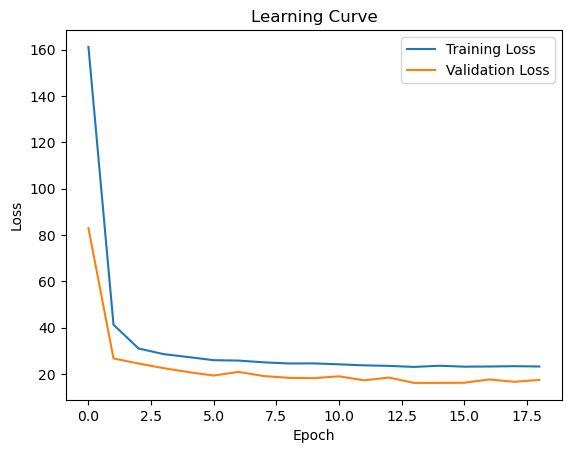

346/346 [==============================] - 15s 44ms/step - loss: 23.2543 - output_points_loss: 14.2995 - output_rebounds_loss: 2.1721 - output_assists_loss: 3.5650 - output_steals_loss: 0.7851 - output_blocks_loss: 0.6084 - output_points_mae: 2.8879 - output_rebounds_mae: 1.0072 - output_assists_mae: 1.3904 - output_steals_mae: 0.6839 - output_blocks_mae: 0.5594 - val_loss: 17.4706 - val_output_points_loss: 10.5872 - val_output_rebounds_loss: 0.5405 - val_output_assists_loss: 3.1267 - val_output_steals_loss: 0.7829 - val_output_blocks_loss: 0.5661 - val_output_points_mae: 2.4718 - val_output_rebounds_mae: 0.5228 - val_output_assists_mae: 1.2717 - val_output_steals_mae: 0.6831 - val_output_blocks_mae: 0.5598
Epoch 20/25
345/346 [============================>.] - ETA: 0s - loss: 23.9329 - output_points_loss: 14.9105 - output_rebounds_loss: 2.1828 - output_assists_loss: 3.5498 - output_steals_loss: 0.7890 - output_blocks_loss: 0.6073 - output_points_mae: 2.9229 - output_rebounds_mae: 1.01

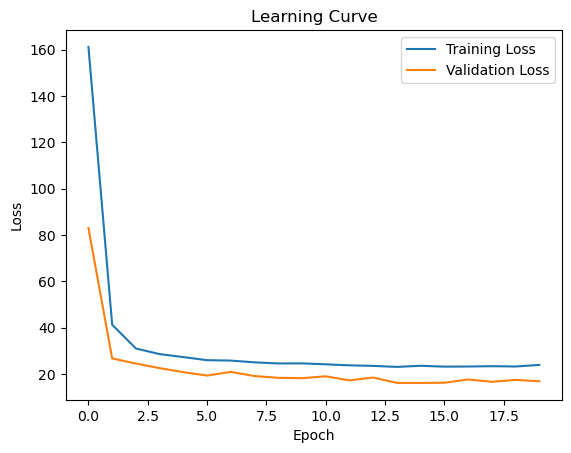

346/346 [==============================] - 16s 45ms/step - loss: 23.9295 - output_points_loss: 14.9083 - output_rebounds_loss: 2.1828 - output_assists_loss: 3.5488 - output_steals_loss: 0.7888 - output_blocks_loss: 0.6072 - output_points_mae: 2.9226 - output_rebounds_mae: 1.0119 - output_assists_mae: 1.3999 - output_steals_mae: 0.6855 - output_blocks_mae: 0.5604 - val_loss: 16.8796 - val_output_points_loss: 9.3727 - val_output_rebounds_loss: 1.2100 - val_output_assists_loss: 3.0213 - val_output_steals_loss: 0.7840 - val_output_blocks_loss: 0.5679 - val_output_points_mae: 2.3435 - val_output_rebounds_mae: 0.9817 - val_output_assists_mae: 1.2626 - val_output_steals_mae: 0.6891 - val_output_blocks_mae: 0.5760
Epoch 21/25
346/346 [==============================] - ETA: 0s - loss: 23.1971 - output_points_loss: 14.1779 - output_rebounds_loss: 2.1874 - output_assists_loss: 3.4812 - output_steals_loss: 0.7876 - output_blocks_loss: 0.6075 - output_points_mae: 2.8787 - output_rebounds_mae: 1.025

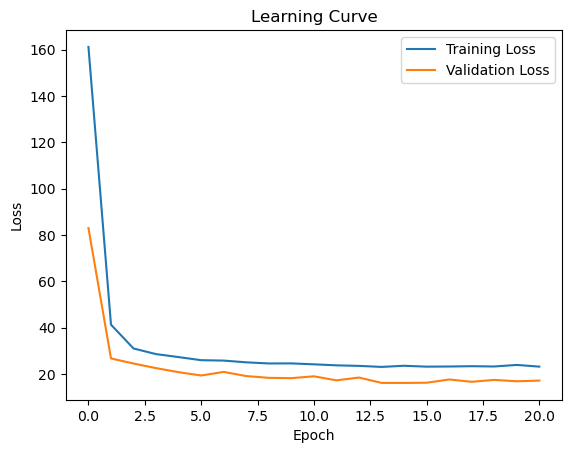

346/346 [==============================] - 15s 45ms/step - loss: 23.1971 - output_points_loss: 14.1779 - output_rebounds_loss: 2.1874 - output_assists_loss: 3.4812 - output_steals_loss: 0.7876 - output_blocks_loss: 0.6075 - output_points_mae: 2.8787 - output_rebounds_mae: 1.0250 - output_assists_mae: 1.3797 - output_steals_mae: 0.6849 - output_blocks_mae: 0.5607 - val_loss: 17.1689 - val_output_points_loss: 9.5682 - val_output_rebounds_loss: 1.1121 - val_output_assists_loss: 3.1492 - val_output_steals_loss: 0.7903 - val_output_blocks_loss: 0.5669 - val_output_points_mae: 2.2934 - val_output_rebounds_mae: 0.8033 - val_output_assists_mae: 1.2554 - val_output_steals_mae: 0.6756 - val_output_blocks_mae: 0.5363
Epoch 22/25
346/346 [==============================] - ETA: 0s - loss: 23.5141 - output_points_loss: 14.3983 - output_rebounds_loss: 2.2069 - output_assists_loss: 3.4920 - output_steals_loss: 0.7868 - output_blocks_loss: 0.6088 - output_points_mae: 2.8887 - output_rebounds_mae: 1.030

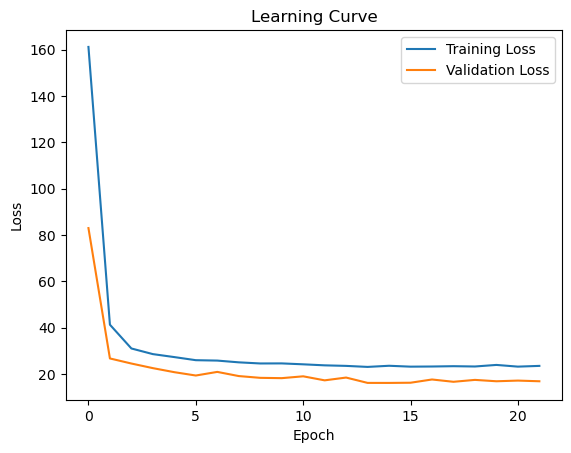

346/346 [==============================] - 15s 44ms/step - loss: 23.5141 - output_points_loss: 14.3983 - output_rebounds_loss: 2.2069 - output_assists_loss: 3.4920 - output_steals_loss: 0.7868 - output_blocks_loss: 0.6088 - output_points_mae: 2.8887 - output_rebounds_mae: 1.0300 - output_assists_mae: 1.3825 - output_steals_mae: 0.6857 - output_blocks_mae: 0.5614 - val_loss: 16.8780 - val_output_points_loss: 9.9738 - val_output_rebounds_loss: 0.5466 - val_output_assists_loss: 2.9511 - val_output_steals_loss: 0.7870 - val_output_blocks_loss: 0.5648 - val_output_points_mae: 2.3535 - val_output_rebounds_mae: 0.5431 - val_output_assists_mae: 1.2510 - val_output_steals_mae: 0.6789 - val_output_blocks_mae: 0.5471
Epoch 23/25
346/346 [==============================] - ETA: 0s - loss: 23.7895 - output_points_loss: 14.6064 - output_rebounds_loss: 2.2301 - output_assists_loss: 3.4593 - output_steals_loss: 0.7891 - output_blocks_loss: 0.6075 - output_points_mae: 2.9016 - output_rebounds_mae: 1.029

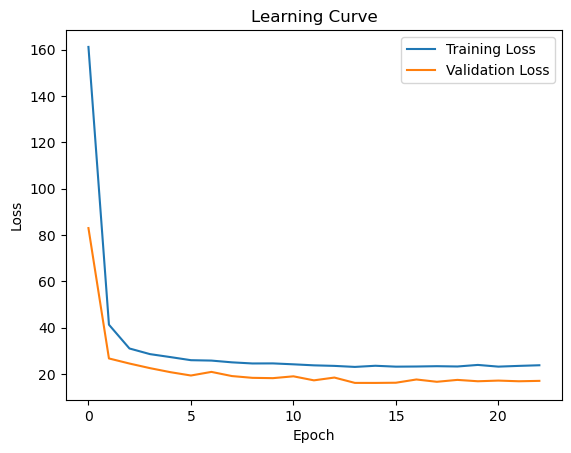

346/346 [==============================] - 15s 45ms/step - loss: 23.7895 - output_points_loss: 14.6064 - output_rebounds_loss: 2.2301 - output_assists_loss: 3.4593 - output_steals_loss: 0.7891 - output_blocks_loss: 0.6075 - output_points_mae: 2.9016 - output_rebounds_mae: 1.0290 - output_assists_mae: 1.3786 - output_steals_mae: 0.6852 - output_blocks_mae: 0.5616 - val_loss: 17.0472 - val_output_points_loss: 9.9697 - val_output_rebounds_loss: 0.6150 - val_output_assists_loss: 2.9703 - val_output_steals_loss: 0.7969 - val_output_blocks_loss: 0.5645 - val_output_points_mae: 2.3472 - val_output_rebounds_mae: 0.6443 - val_output_assists_mae: 1.2437 - val_output_steals_mae: 0.6712 - val_output_blocks_mae: 0.5543
Epoch 24/25
345/346 [============================>.] - ETA: 0s - loss: 23.6042 - output_points_loss: 14.3454 - output_rebounds_loss: 2.2179 - output_assists_loss: 3.4685 - output_steals_loss: 0.7887 - output_blocks_loss: 0.6105 - output_points_mae: 2.8664 - output_rebounds_mae: 1.015

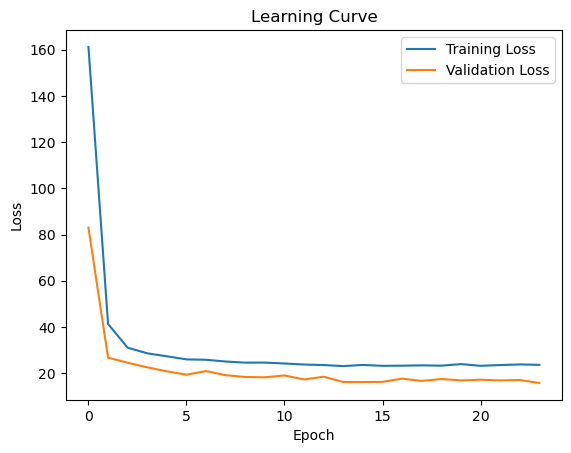

346/346 [==============================] - 16s 45ms/step - loss: 23.6164 - output_points_loss: 14.3581 - output_rebounds_loss: 2.2174 - output_assists_loss: 3.4686 - output_steals_loss: 0.7885 - output_blocks_loss: 0.6106 - output_points_mae: 2.8680 - output_rebounds_mae: 1.0152 - output_assists_mae: 1.3765 - output_steals_mae: 0.6851 - output_blocks_mae: 0.5618 - val_loss: 15.7870 - val_output_points_loss: 8.5557 - val_output_rebounds_loss: 0.6807 - val_output_assists_loss: 3.0038 - val_output_steals_loss: 0.7892 - val_output_blocks_loss: 0.5672 - val_output_points_mae: 2.2093 - val_output_rebounds_mae: 0.5782 - val_output_assists_mae: 1.3022 - val_output_steals_mae: 0.7009 - val_output_blocks_mae: 0.5354
Epoch 25/25
346/346 [==============================] - ETA: 0s - loss: 23.9055 - output_points_loss: 14.6258 - output_rebounds_loss: 2.1854 - output_assists_loss: 3.4625 - output_steals_loss: 0.7870 - output_blocks_loss: 0.6087 - output_points_mae: 2.9060 - output_rebounds_mae: 1.030

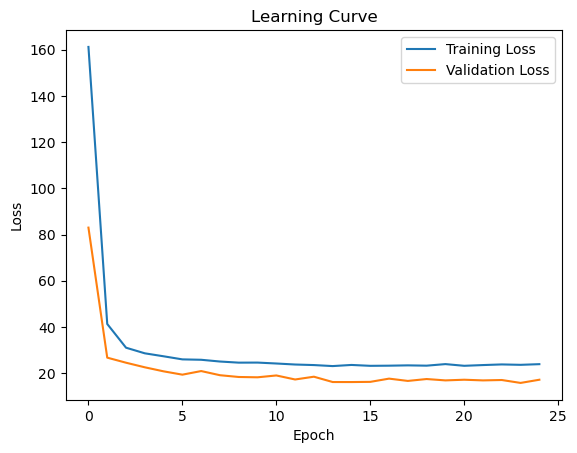

346/346 [==============================] - 15s 44ms/step - loss: 23.9055 - output_points_loss: 14.6258 - output_rebounds_loss: 2.1854 - output_assists_loss: 3.4625 - output_steals_loss: 0.7870 - output_blocks_loss: 0.6087 - output_points_mae: 2.9060 - output_rebounds_mae: 1.0303 - output_assists_mae: 1.3880 - output_steals_mae: 0.6844 - output_blocks_mae: 0.5602 - val_loss: 17.1687 - val_output_points_loss: 9.7262 - val_output_rebounds_loss: 0.8472 - val_output_assists_loss: 2.9567 - val_output_steals_loss: 0.7859 - val_output_blocks_loss: 0.5690 - val_output_points_mae: 2.4383 - val_output_rebounds_mae: 0.6471 - val_output_assists_mae: 1.2469 - val_output_steals_mae: 0.6942 - val_output_blocks_mae: 0.5313


In [65]:
# train model on 2022-2023 season data

# create learning curve callback object
learning_curve_callback = LearningCurveCallback(patience=10)

# set learning rate and create learning schedule with decay (hyper parameter learning rate, decay steps, and decay rate)
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9)

# create optimizer
optimizer = Adam(learning_rate=lr_schedule, clipnorm=1.0)

# complie model with optimizer and loss metrics
model.compile(optimizer=optimizer,
              loss={'output_points':'mean_squared_error', 'output_rebounds':'mean_squared_error', 'output_assists':'mean_squared_error', 'output_steals':'mean_squared_error', 'output_blocks':'mean_squared_error'},
              metrics={'output_points':'mae', 'output_rebounds':'mae', 'output_assists':'mae', 'output_steals':'mae', 'output_blocks':'mae'})

# train model with 2022-2023 season data with set hyperparatmeters (epochs, batch_size, and validation_split
model.fit(
    {'input_player_name': X_train[:, feature_dict['PLAYER_NAME']].reshape(-1,1),
     'input_player_team': X_train[:, feature_dict['TEAM_ABBREVIATION_x']].reshape(-1,1),
     'input_opponent_team': X_train[:, feature_dict['TEAM_ABBREVIATION']].reshape(-1,1),
     'input_features': X_train[:, 3:]},
    {'output_points': y_train[:, 0], 'output_rebounds': y_train[:, 1], 'output_assists': y_train[:, 2], 'output_steals': y_train[:, 3], 'output_blocks': y_train[:, 4]},
    epochs=25, batch_size=48, validation_split=0.2,
    callbacks=[learning_curve_callback])


Epoch 1/20
518/518 [==============================] - ETA: 0s - loss: 25.6737 - output_points_loss: 16.1379 - output_rebounds_loss: 2.2405 - output_assists_loss: 3.5853 - output_steals_loss: 0.7902 - output_blocks_loss: 0.6055 - output_points_mae: 3.0457 - output_rebounds_mae: 1.0371 - output_assists_mae: 1.4035 - output_steals_mae: 0.6865 - output_blocks_mae: 0.5580

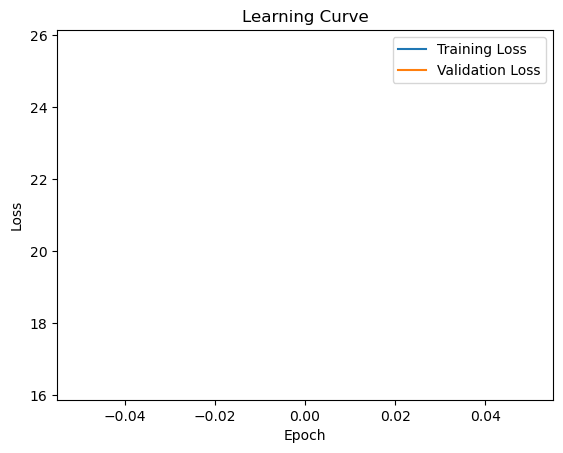

518/518 [==============================] - 24s 46ms/step - loss: 25.6737 - output_points_loss: 16.1379 - output_rebounds_loss: 2.2405 - output_assists_loss: 3.5853 - output_steals_loss: 0.7902 - output_blocks_loss: 0.6055 - output_points_mae: 3.0457 - output_rebounds_mae: 1.0371 - output_assists_mae: 1.4035 - output_steals_mae: 0.6865 - output_blocks_mae: 0.5580 - val_loss: 16.3410 - val_output_points_loss: 8.5885 - val_output_rebounds_loss: 1.0530 - val_output_assists_loss: 2.9885 - val_output_steals_loss: 0.7893 - val_output_blocks_loss: 0.5647 - val_output_points_mae: 2.2058 - val_output_rebounds_mae: 0.8773 - val_output_assists_mae: 1.2789 - val_output_steals_mae: 0.7032 - val_output_blocks_mae: 0.5638
Epoch 2/20
518/518 [==============================] - ETA: 0s - loss: 25.5462 - output_points_loss: 15.8305 - output_rebounds_loss: 2.2742 - output_assists_loss: 3.6366 - output_steals_loss: 0.7891 - output_blocks_loss: 0.6048 - output_points_mae: 3.0322 - output_rebounds_mae: 1.0326

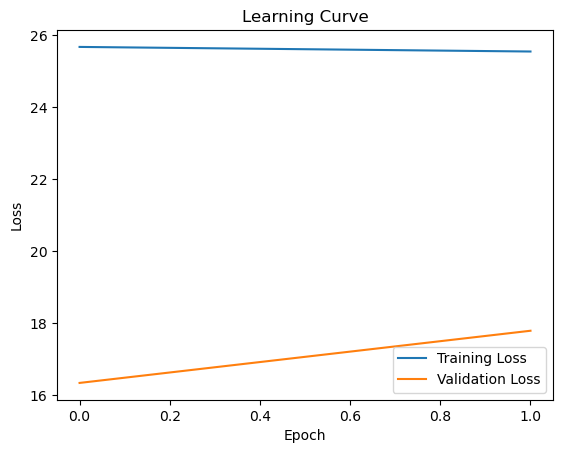

518/518 [==============================] - 23s 44ms/step - loss: 25.5462 - output_points_loss: 15.8305 - output_rebounds_loss: 2.2742 - output_assists_loss: 3.6366 - output_steals_loss: 0.7891 - output_blocks_loss: 0.6048 - output_points_mae: 3.0322 - output_rebounds_mae: 1.0326 - output_assists_mae: 1.4037 - output_steals_mae: 0.6863 - output_blocks_mae: 0.5551 - val_loss: 17.7902 - val_output_points_loss: 9.1105 - val_output_rebounds_loss: 1.8107 - val_output_assists_loss: 3.0708 - val_output_steals_loss: 0.7895 - val_output_blocks_loss: 0.5674 - val_output_points_mae: 2.2902 - val_output_rebounds_mae: 1.0625 - val_output_assists_mae: 1.2606 - val_output_steals_mae: 0.6843 - val_output_blocks_mae: 0.5396
Epoch 3/20
518/518 [==============================] - ETA: 0s - loss: 25.2554 - output_points_loss: 15.5948 - output_rebounds_loss: 2.1929 - output_assists_loss: 3.6068 - output_steals_loss: 0.7917 - output_blocks_loss: 0.6062 - output_points_mae: 2.9847 - output_rebounds_mae: 0.9969

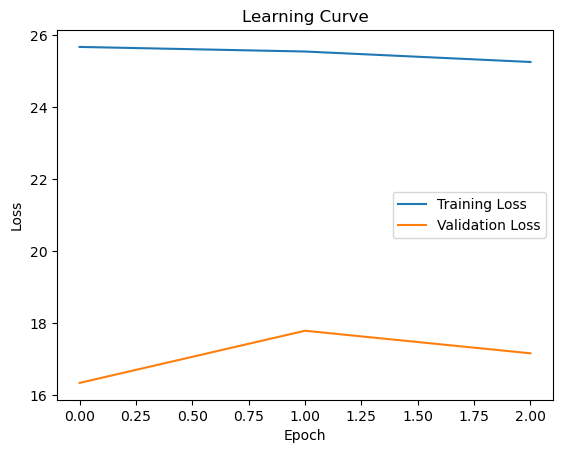

518/518 [==============================] - 23s 44ms/step - loss: 25.2554 - output_points_loss: 15.5948 - output_rebounds_loss: 2.1929 - output_assists_loss: 3.6068 - output_steals_loss: 0.7917 - output_blocks_loss: 0.6062 - output_points_mae: 2.9847 - output_rebounds_mae: 0.9969 - output_assists_mae: 1.4123 - output_steals_mae: 0.6877 - output_blocks_mae: 0.5584 - val_loss: 17.1633 - val_output_points_loss: 8.8433 - val_output_rebounds_loss: 1.2978 - val_output_assists_loss: 3.1695 - val_output_steals_loss: 0.7890 - val_output_blocks_loss: 0.5754 - val_output_points_mae: 2.2254 - val_output_rebounds_mae: 0.8349 - val_output_assists_mae: 1.3808 - val_output_steals_mae: 0.6906 - val_output_blocks_mae: 0.5086
Epoch 4/20
518/518 [==============================] - ETA: 0s - loss: 25.1594 - output_points_loss: 15.3687 - output_rebounds_loss: 2.2895 - output_assists_loss: 3.5809 - output_steals_loss: 0.7910 - output_blocks_loss: 0.6088 - output_points_mae: 2.9884 - output_rebounds_mae: 1.0101

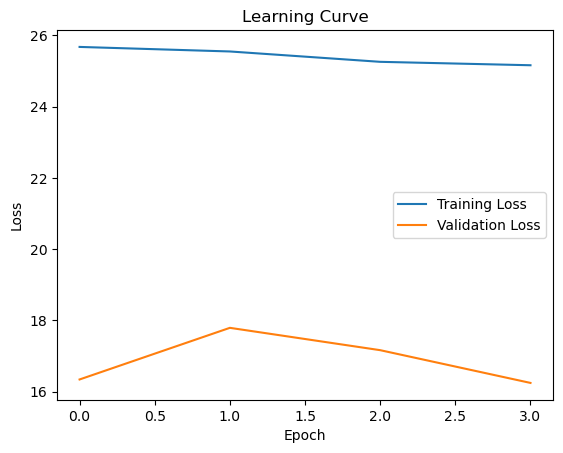

518/518 [==============================] - 22s 43ms/step - loss: 25.1594 - output_points_loss: 15.3687 - output_rebounds_loss: 2.2895 - output_assists_loss: 3.5809 - output_steals_loss: 0.7910 - output_blocks_loss: 0.6088 - output_points_mae: 2.9884 - output_rebounds_mae: 1.0101 - output_assists_mae: 1.4007 - output_steals_mae: 0.6859 - output_blocks_mae: 0.5586 - val_loss: 16.2442 - val_output_points_loss: 8.5504 - val_output_rebounds_loss: 0.8357 - val_output_assists_loss: 2.9551 - val_output_steals_loss: 0.7879 - val_output_blocks_loss: 0.5695 - val_output_points_mae: 2.1948 - val_output_rebounds_mae: 0.6801 - val_output_assists_mae: 1.2837 - val_output_steals_mae: 0.6857 - val_output_blocks_mae: 0.5350
Epoch 5/20
518/518 [==============================] - ETA: 0s - loss: 25.7476 - output_points_loss: 15.8354 - output_rebounds_loss: 2.3789 - output_assists_loss: 3.5672 - output_steals_loss: 0.7921 - output_blocks_loss: 0.6079 - output_points_mae: 3.0043 - output_rebounds_mae: 1.0269

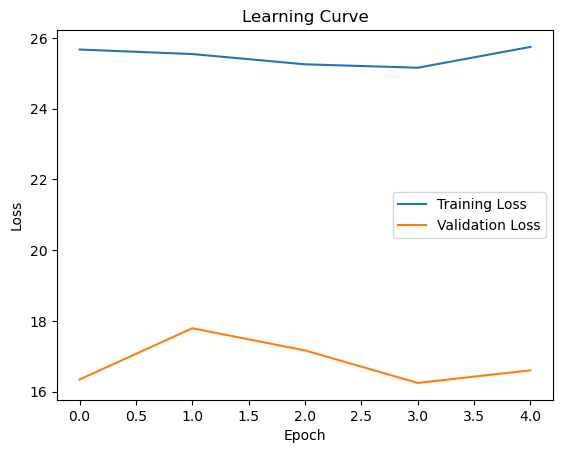

518/518 [==============================] - 23s 44ms/step - loss: 25.7476 - output_points_loss: 15.8354 - output_rebounds_loss: 2.3789 - output_assists_loss: 3.5672 - output_steals_loss: 0.7921 - output_blocks_loss: 0.6079 - output_points_mae: 3.0043 - output_rebounds_mae: 1.0269 - output_assists_mae: 1.4004 - output_steals_mae: 0.6858 - output_blocks_mae: 0.5582 - val_loss: 16.6007 - val_output_points_loss: 8.9013 - val_output_rebounds_loss: 0.8587 - val_output_assists_loss: 2.8991 - val_output_steals_loss: 0.7882 - val_output_blocks_loss: 0.5675 - val_output_points_mae: 2.2642 - val_output_rebounds_mae: 0.6653 - val_output_assists_mae: 1.2494 - val_output_steals_mae: 0.6887 - val_output_blocks_mae: 0.5412
Epoch 6/20
518/518 [==============================] - ETA: 0s - loss: 25.3312 - output_points_loss: 15.4977 - output_rebounds_loss: 2.2807 - output_assists_loss: 3.5473 - output_steals_loss: 0.7911 - output_blocks_loss: 0.6081 - output_points_mae: 2.9917 - output_rebounds_mae: 0.9996

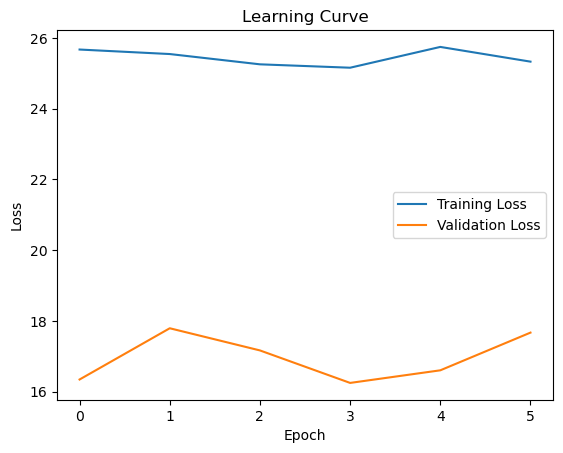

518/518 [==============================] - 23s 45ms/step - loss: 25.3312 - output_points_loss: 15.4977 - output_rebounds_loss: 2.2807 - output_assists_loss: 3.5473 - output_steals_loss: 0.7911 - output_blocks_loss: 0.6081 - output_points_mae: 2.9917 - output_rebounds_mae: 0.9996 - output_assists_mae: 1.3957 - output_steals_mae: 0.6871 - output_blocks_mae: 0.5582 - val_loss: 17.6674 - val_output_points_loss: 9.9083 - val_output_rebounds_loss: 0.8355 - val_output_assists_loss: 2.9319 - val_output_steals_loss: 0.7902 - val_output_blocks_loss: 0.5675 - val_output_points_mae: 2.3107 - val_output_rebounds_mae: 0.6823 - val_output_assists_mae: 1.2687 - val_output_steals_mae: 0.6980 - val_output_blocks_mae: 0.5483
Epoch 7/20
518/518 [==============================] - ETA: 0s - loss: 25.4023 - output_points_loss: 15.5476 - output_rebounds_loss: 2.2536 - output_assists_loss: 3.5645 - output_steals_loss: 0.7915 - output_blocks_loss: 0.6092 - output_points_mae: 2.9996 - output_rebounds_mae: 1.0168

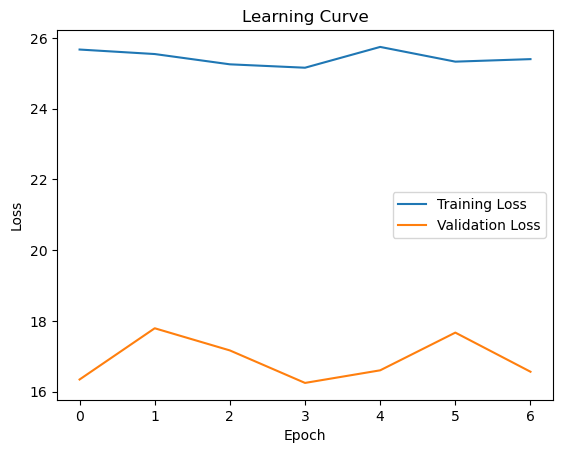

518/518 [==============================] - 23s 45ms/step - loss: 25.4023 - output_points_loss: 15.5476 - output_rebounds_loss: 2.2536 - output_assists_loss: 3.5645 - output_steals_loss: 0.7915 - output_blocks_loss: 0.6092 - output_points_mae: 2.9996 - output_rebounds_mae: 1.0168 - output_assists_mae: 1.3910 - output_steals_mae: 0.6870 - output_blocks_mae: 0.5580 - val_loss: 16.5606 - val_output_points_loss: 8.7060 - val_output_rebounds_loss: 0.9135 - val_output_assists_loss: 2.9390 - val_output_steals_loss: 0.7903 - val_output_blocks_loss: 0.5701 - val_output_points_mae: 2.2123 - val_output_rebounds_mae: 0.6978 - val_output_assists_mae: 1.2403 - val_output_steals_mae: 0.7002 - val_output_blocks_mae: 0.5341
Epoch 8/20
518/518 [==============================] - ETA: 0s - loss: 25.4882 - output_points_loss: 15.4080 - output_rebounds_loss: 2.4018 - output_assists_loss: 3.6080 - output_steals_loss: 0.7902 - output_blocks_loss: 0.6094 - output_points_mae: 2.9627 - output_rebounds_mae: 1.0198

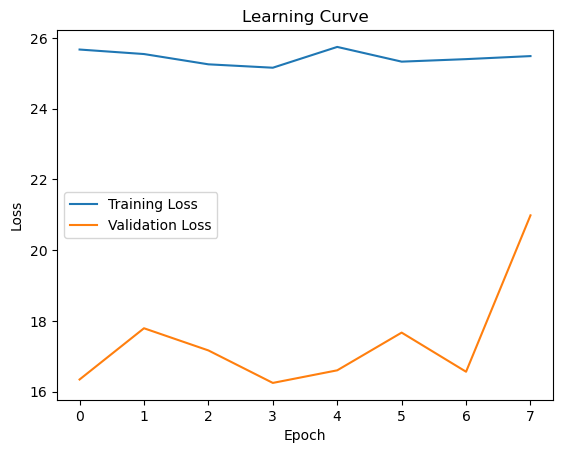

518/518 [==============================] - 23s 45ms/step - loss: 25.4882 - output_points_loss: 15.4080 - output_rebounds_loss: 2.4018 - output_assists_loss: 3.6080 - output_steals_loss: 0.7902 - output_blocks_loss: 0.6094 - output_points_mae: 2.9627 - output_rebounds_mae: 1.0198 - output_assists_mae: 1.3965 - output_steals_mae: 0.6873 - output_blocks_mae: 0.5589 - val_loss: 20.9840 - val_output_points_loss: 13.0469 - val_output_rebounds_loss: 0.9091 - val_output_assists_loss: 2.9685 - val_output_steals_loss: 0.7895 - val_output_blocks_loss: 0.5692 - val_output_points_mae: 2.9510 - val_output_rebounds_mae: 0.7587 - val_output_assists_mae: 1.2504 - val_output_steals_mae: 0.6828 - val_output_blocks_mae: 0.5691
Epoch 9/20
518/518 [==============================] - ETA: 0s - loss: 25.9515 - output_points_loss: 15.8131 - output_rebounds_loss: 2.4481 - output_assists_loss: 3.5599 - output_steals_loss: 0.7898 - output_blocks_loss: 0.6114 - output_points_mae: 3.0176 - output_rebounds_mae: 1.026

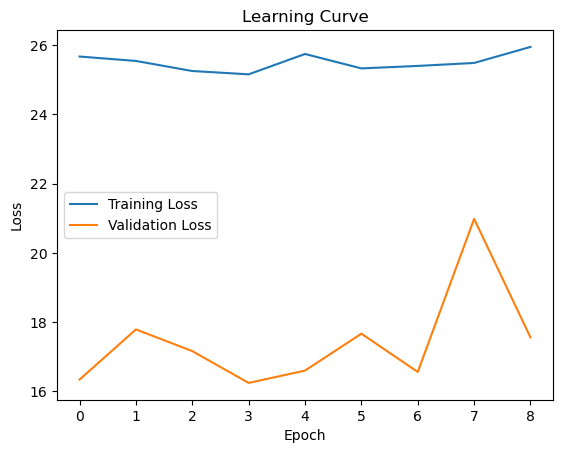

518/518 [==============================] - 23s 45ms/step - loss: 25.9515 - output_points_loss: 15.8131 - output_rebounds_loss: 2.4481 - output_assists_loss: 3.5599 - output_steals_loss: 0.7898 - output_blocks_loss: 0.6114 - output_points_mae: 3.0176 - output_rebounds_mae: 1.0266 - output_assists_mae: 1.3947 - output_steals_mae: 0.6872 - output_blocks_mae: 0.5601 - val_loss: 17.5585 - val_output_points_loss: 9.4722 - val_output_rebounds_loss: 1.0636 - val_output_assists_loss: 2.9004 - val_output_steals_loss: 0.7901 - val_output_blocks_loss: 0.5692 - val_output_points_mae: 2.3360 - val_output_rebounds_mae: 0.7328 - val_output_assists_mae: 1.2461 - val_output_steals_mae: 0.6942 - val_output_blocks_mae: 0.5413
Epoch 10/20
518/518 [==============================] - ETA: 0s - loss: 25.2645 - output_points_loss: 15.3077 - output_rebounds_loss: 2.2949 - output_assists_loss: 3.4823 - output_steals_loss: 0.7882 - output_blocks_loss: 0.6078 - output_points_mae: 2.9518 - output_rebounds_mae: 1.008

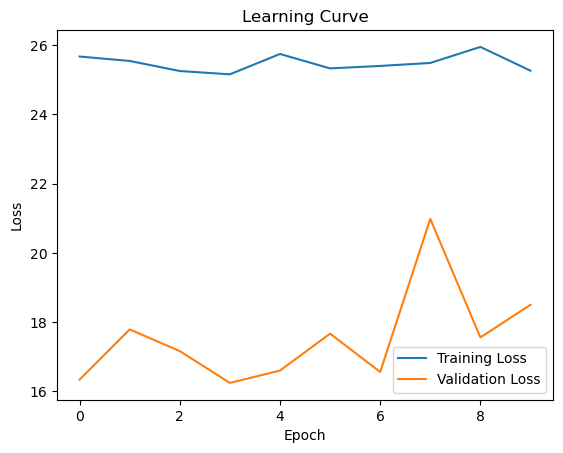

518/518 [==============================] - 24s 47ms/step - loss: 25.2645 - output_points_loss: 15.3077 - output_rebounds_loss: 2.2949 - output_assists_loss: 3.4823 - output_steals_loss: 0.7882 - output_blocks_loss: 0.6078 - output_points_mae: 2.9518 - output_rebounds_mae: 1.0088 - output_assists_mae: 1.3798 - output_steals_mae: 0.6859 - output_blocks_mae: 0.5587 - val_loss: 18.5019 - val_output_points_loss: 9.1765 - val_output_rebounds_loss: 2.2577 - val_output_assists_loss: 2.8922 - val_output_steals_loss: 0.7909 - val_output_blocks_loss: 0.5763 - val_output_points_mae: 2.2433 - val_output_rebounds_mae: 1.3323 - val_output_assists_mae: 1.2497 - val_output_steals_mae: 0.6883 - val_output_blocks_mae: 0.5938
Epoch 11/20
518/518 [==============================] - ETA: 0s - loss: 25.7272 - output_points_loss: 15.6725 - output_rebounds_loss: 2.3851 - output_assists_loss: 3.4336 - output_steals_loss: 0.7910 - output_blocks_loss: 0.6094 - output_points_mae: 3.0053 - output_rebounds_mae: 1.021

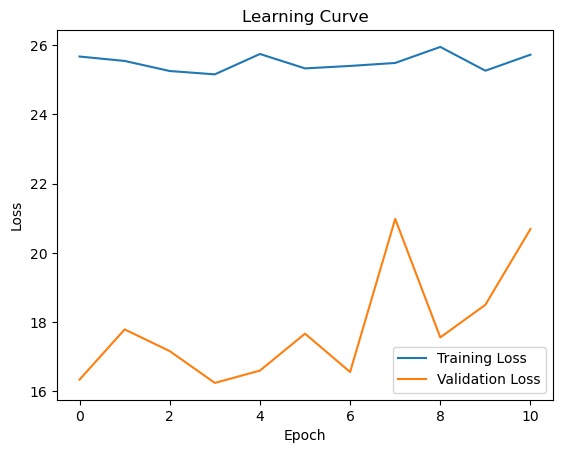

518/518 [==============================] - 24s 47ms/step - loss: 25.7272 - output_points_loss: 15.6725 - output_rebounds_loss: 2.3851 - output_assists_loss: 3.4336 - output_steals_loss: 0.7910 - output_blocks_loss: 0.6094 - output_points_mae: 3.0053 - output_rebounds_mae: 1.0213 - output_assists_mae: 1.3813 - output_steals_mae: 0.6867 - output_blocks_mae: 0.5585 - val_loss: 20.6915 - val_output_points_loss: 10.7740 - val_output_rebounds_loss: 2.8384 - val_output_assists_loss: 2.8488 - val_output_steals_loss: 0.7875 - val_output_blocks_loss: 0.5874 - val_output_points_mae: 2.6358 - val_output_rebounds_mae: 1.5213 - val_output_assists_mae: 1.2443 - val_output_steals_mae: 0.6906 - val_output_blocks_mae: 0.6088
Epoch 12/20
518/518 [==============================] - ETA: 0s - loss: 25.8282 - output_points_loss: 15.7449 - output_rebounds_loss: 2.4423 - output_assists_loss: 3.3570 - output_steals_loss: 0.7871 - output_blocks_loss: 0.6119 - output_points_mae: 3.0045 - output_rebounds_mae: 1.02

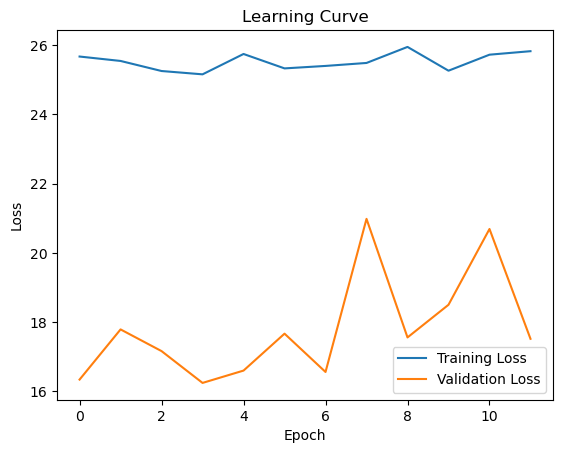

518/518 [==============================] - 24s 46ms/step - loss: 25.8282 - output_points_loss: 15.7449 - output_rebounds_loss: 2.4423 - output_assists_loss: 3.3570 - output_steals_loss: 0.7871 - output_blocks_loss: 0.6119 - output_points_mae: 3.0045 - output_rebounds_mae: 1.0203 - output_assists_mae: 1.3612 - output_steals_mae: 0.6846 - output_blocks_mae: 0.5620 - val_loss: 17.5188 - val_output_points_loss: 8.6840 - val_output_rebounds_loss: 1.7046 - val_output_assists_loss: 2.8491 - val_output_steals_loss: 0.7970 - val_output_blocks_loss: 0.5720 - val_output_points_mae: 2.2034 - val_output_rebounds_mae: 1.1419 - val_output_assists_mae: 1.2209 - val_output_steals_mae: 0.7065 - val_output_blocks_mae: 0.5801
Epoch 13/20
 57/518 [==>...........................] - ETA: 20s - loss: 25.2641 - output_points_loss: 15.2937 - output_rebounds_loss: 2.4187 - output_assists_loss: 3.2391 - output_steals_loss: 0.7910 - output_blocks_loss: 0.6066 - output_points_mae: 2.9503 - output_rebounds_mae: 1.02

In [ ]:
# train model on 2023-2024 season data

learning_curve_callback = LearningCurveCallback(patience=20)


# normalize new numeric data
normalizer.adapt(X_train_2024[:, 3:])

# fit model with new data
model.fit(
    {'input_player_name': X_train_2024[:, feature_dict['PLAYER_NAME']].reshape(-1,1),
     'input_player_team': X_train_2024[:, feature_dict['TEAM_ABBREVIATION_x']].reshape(-1,1),
     'input_opponent_team': X_train_2024[:, feature_dict['TEAM_ABBREVIATION']].reshape(-1,1),
     'input_features': X_train_2024[:, 3:]},
    {'output_points': y_train_2024[:, 0], 'output_rebounds': y_train_2024[:, 1], 'output_assists': y_train_2024[:, 2], 'output_steals': y_train_2024[:, 3], 'output_blocks': y_train_2024[:, 4]},
    epochs=20, batch_size=32, validation_split=0.2,
    callbacks=[learning_curve_callback])




In [71]:
test_loss = model.evaluate(
    {'input_player_name': X_test[:, feature_dict['PLAYER_NAME']].reshape(-1,1),
     'input_player_team': X_test[:, feature_dict['TEAM_ABBREVIATION_x']].reshape(-1,1),
     'input_opponent_team': X_test[:, feature_dict['TEAM_ABBREVIATION']].reshape(-1,1),
     'input_features': X_test[:, 3:]},
    {'output_points': y_test[:, 0], 'output_rebounds': y_test[:, 1], 'output_assists': y_test[:, 2], 'output_steals': y_test[:, 3], 'output_blocks': y_test[:, 4]})

print("Test loss:", test_loss)

162/162 [==============================] - 4s 22ms/step - loss: 18.7648 - output_points_loss: 9.3922 - output_rebounds_loss: 0.6734 - output_assists_loss: 3.5588 - output_steals_loss: 0.8065 - output_blocks_loss: 0.5723 - output_points_mae: 2.3065 - output_rebounds_mae: 0.6609 - output_assists_mae: 1.4220 - output_steals_mae: 0.6821 - output_blocks_mae: 0.5681
Test loss: [18.764781951904297, 9.392247200012207, 0.6733968257904053, 3.558830976486206, 0.8065177798271179, 0.57225501537323, 2.3064842224121094, 0.6608748435974121, 1.4219962358474731, 0.682134211063385, 0.568085789680481]


In [72]:
def player_stats_prediction(player_name, dataset, player_team, opponent_team):
    
    # from a merged dataset of player stats, player team stats, and opponent team stats, collect data from specific games
    player_dataset = dataset[dataset['PLAYER_NAME'] == player_name]
    player_dataset = player_dataset[player_dataset['TEAM_ABBREVIATION'] == opponent_team]
    player_dataset = player_dataset[player_dataset['TEAM_ABBREVIATION_x'] == player_team]

    # from sampled dataset, collect specific input data: separate into numerical and categorical data
    player_num_stats = player_dataset[['MIN_x', 'FGA_x', 'FG_PCT_x', 'FG3M_x', 'FG3A_x', 'FG3_PCT_x', 'FTM_x', 'FTA_x', 'FT_PCT_x', 'OREB_x', 'DREB_x', 'TOV_x', 'PF_x', 'PLUS_MINUS_x', 'PTS_y', 'FGM_y', 'FGA_y', 'FG_PCT_y', 'FG3M_y', 'FG3A_y', 'FG3_PCT_y', 'FTA_y', 'FT_PCT_y', 'OREB_y', 'DREB_y', 'REB_y', 'AST_y', 'STL_y', 'BLK_y', 'TOV_y', 'PF_y', 'PLUS_MINUS_y', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'PTS_x', 'REB_x', 'AST_x', 'STL_x', 'BLK_x']] 

    # find average stat values for final numerical input line
    avgs = player_num_stats.mean()
    player_num_data = [avgs]

    # struture average numercial stat data into numpy array
    player_num_array = np.array(player_num_data)
    
    # remove NaN values from array
    player_num_array = np.nan_to_num(player_num_array, nan=0)
    
    # strucutre data into inputs (X) and outputs (Y)
    # the Y data is for testing loss
    player_X_num = player_num_array[:, [num_feature_dict['MIN_x'], num_feature_dict['FGA_x'], num_feature_dict['FG_PCT_x'], 
                     num_feature_dict['FG3M_x'], num_feature_dict['FG3A_x'], num_feature_dict['FG3_PCT_x'], 
                     num_feature_dict['OREB_x'], num_feature_dict['DREB_x'], num_feature_dict['TOV_x'], 
                     num_feature_dict['PF_x'], num_feature_dict['PLUS_MINUS_x'], num_feature_dict['PTS_y'], 
                     num_feature_dict['FGM_y'], num_feature_dict['FGA_y'], num_feature_dict['FG_PCT_y'], 
                     num_feature_dict['FG3M_y'], num_feature_dict['FG3A_y'], num_feature_dict['FG3_PCT_y'], 
                     num_feature_dict['FTA_y'], num_feature_dict['FT_PCT_y'], num_feature_dict['OREB_y'], 
                     num_feature_dict['DREB_y'], num_feature_dict['REB_y'], num_feature_dict['AST_y'], 
                     num_feature_dict['STL_y'], num_feature_dict['BLK_y'], num_feature_dict['TOV_y'], 
                     num_feature_dict['PF_y'], num_feature_dict['PLUS_MINUS_y'], num_feature_dict['PTS'], 
                     num_feature_dict['FGM'], num_feature_dict['FGA'], num_feature_dict['FG_PCT'], 
                     num_feature_dict['FG3M'], num_feature_dict['FG3A'], num_feature_dict['FG3_PCT'], 
                     num_feature_dict['FTM'], num_feature_dict['FTA'], num_feature_dict['FT_PCT'], 
                     num_feature_dict['OREB'], num_feature_dict['DREB'], num_feature_dict['REB'], 
                     num_feature_dict['AST'], num_feature_dict['STL'], num_feature_dict['BLK'], 
                     num_feature_dict['TOV'], num_feature_dict['PF'], num_feature_dict['PLUS_MINUS']]]

    player_y = player_num_array[:, 51:]
    
    input_data = {
    'input_player_name': np.array(player_name_encoder.transform([player_name])[0]).reshape(-1,1),
    'input_player_team': np.array(team_encoder.transform([player_team])[0]).reshape(-1,1),
    'input_opponent_team': np.array(team_encoder.transform([opponent_team])[0]).reshape(-1,1),
    'input_features': player_X_num
    }

    predictions = model.predict(input_data)

    outputs = {'Points': predictions[0][0][0], 
               'Rebounds': predictions[1][0][0],
               'Assists' : predictions[2][0][0],
               'Steals' : predictions[3][0][0],
               'Blocks' : predictions[4][0][0]
              } 
    
    print(outputs)
    
    test_loss = model.evaluate(
    {'input_player_name': np.array(player_name_encoder.transform([player_name])[0]).reshape(-1,1),
     'input_player_team': np.array(team_encoder.transform([player_team])[0]).reshape(-1,1),
     'input_opponent_team': np.array(team_encoder.transform([opponent_team])[0]).reshape(-1,1),
     'input_features': player_X_num},
    {'output_points': player_y[:, 0], 'output_rebounds': player_y[:, 1], 'output_assists': player_y[:, 2], 'output_steals': player_y[:, 3], 'output_blocks': player_y[:, 4]})

    print("Test loss:", test_loss)

In [81]:
# vertically merging last season's and this season's dataframes
merged_final = pd.concat([final, final_2024], axis=0, ignore_index=True)

In [95]:
player_stats_prediction('Joel Embiid', merged_final, 'PHI', 'TOR')

1/1 [==============================] - 0s 26ms/step
{'Points': 25.104803, 'Rebounds': 5.132779, 'Assists': 4.4727488, 'Steals': 1.2608528, 'Blocks': 0.36018115}
1/1 [==============================] - 0s 53ms/step - loss: 34.9281 - output_points_loss: 29.1082 - output_rebounds_loss: 0.1465 - output_assists_loss: 1.6314 - output_steals_loss: 0.2610 - output_blocks_loss: 0.0195 - output_points_mae: 5.3952 - output_rebounds_mae: 0.3828 - output_assists_mae: 1.2773 - output_steals_mae: 0.5109 - output_blocks_mae: 0.1398
Test loss: [34.9280891418457, 29.108150482177734, 0.14651985466480255, 1.6313707828521729, 0.2609705924987793, 0.019549310207366943, 5.395196914672852, 0.3827791213989258, 1.2772512435913086, 0.5108528137207031, 0.13981884717941284]


In [103]:
player_stats_prediction('Kevin Durant', merged_final, 'PHX', 'SAS')

1/1 [==============================] - 0s 22ms/step
{'Points': 24.808798, 'Rebounds': 4.70243, 'Assists': 5.298952, 'Steals': 1.3532927, 'Blocks': 0.31789872}
1/1 [==============================] - 0s 52ms/step - loss: 13.8930 - output_points_loss: 7.8893 - output_rebounds_loss: 1.4458 - output_assists_loss: 0.6383 - output_steals_loss: 0.1248 - output_blocks_loss: 0.0332 - output_points_mae: 2.8088 - output_rebounds_mae: 1.2024 - output_assists_mae: 0.7990 - output_steals_mae: 0.3533 - output_blocks_mae: 0.1821
Test loss: [13.893013954162598, 7.889345169067383, 1.445837378501892, 0.6383244395256042, 0.12481573224067688, 0.03316087648272514, 2.808797836303711, 1.2024297714233398, 0.7989521026611328, 0.35329270362854004, 0.1821012794971466]
